# When AI Goes Wrong: Dissecting 6,000 Model Failures (and How They Came Back to Life)

---

There is a graveyard somewhere. Not one with headstones and flowers, but one filled with abandoned Jupyter notebooks, killed training runs, and models that were quietly deleted after producing embarrassingly bad predictions. We have all been there. That moment when your validation loss suddenly spikes, your F1-score looks like a phone number from the 1800s, and you question every life decision that led you to machine learning.

But here is the thing: **failure is the most underrated teacher in ML**. We obsess over SOTA results and leaderboard climbs, yet the real wisdom lives in the wreckage.

Today, we are performing an autopsy on 6,000 synthetic AI projects that went sideways. Class imbalance, label noise, overfitting, deployment drift - they are all here, documented with surgical precision. More importantly, we have records of what fixed them. Think of this as a post-mortem turned resurrection manual.

**What we will uncover:**
- The anatomy of ML failure across domains (fraud, medical, NLP, and more)
- Which failure types hit hardest, and which are just noise
- The recovery playbook: what actually works when your model is dying

Buckle up. This is going to be enlightening.

In [1]:
# ============================================================
# IMPORTS AND CONFIGURATION
# The ritual we all perform before the real work begins
# ============================================================

import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy import stats
from scipy.stats import shapiro, chi2_contingency, mannwhitneyu, f_oneway, kruskal

# Preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Evaluation
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_auc_score,
                             precision_score, recall_score, roc_curve,
                             precision_recall_curve, average_precision_score)

# Style configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Color palette for our failure types
FAILURE_COLORS = {
    'class_imbalance': '#e74c3c',
    'data_quality': '#3498db',
    'deployment_shift': '#2ecc71',
    'label_noise': '#9b59b6',
    'model_complexity': '#f39c12',
    'poor_generalization': '#1abc9c'
}

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)

print("Environment ready. Let the investigation begin.")

Environment ready. Let the investigation begin.


---

## 2. Data Loading and First Impressions

Let us meet our dataset. Every row is a story of an AI project that stumbled, the diagnosis of why it fell, and the treatment that brought it back. 6,000 case studies, spanning 2018 to 2026, across six domains. This is basically a medical chart for machine learning models.

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("emirhanakku/ai-model-failure-and-recovery-dataset-20182026")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/ai-model-failure-and-recovery-dataset-20182026


In [3]:
print(os.listdir(path))

['synthetic_ai_model_failure_recovery.csv']


In [4]:
# ============================================================
# LOADING THE PATIENT FILES
# ============================================================

df = pd.read_csv(os.path.join(path,'synthetic_ai_model_failure_recovery.csv'))

print("=" * 60)
print("DATASET VITAL SIGNS")
print("=" * 60)
print(f"Total Projects Analyzed: {df.shape[0]:,}")
print(f"Features Captured: {df.shape[1]}")
print(f"Memory Footprint: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print("=" * 60)

DATASET VITAL SIGNS
Total Projects Analyzed: 6,000
Features Captured: 24
Memory Footprint: 2.81 MB


In [5]:
# First glimpse at the data structure
print("\nColumn Overview:")
print("-" * 60)
for i, (col, dtype) in enumerate(df.dtypes.items(), 1):
    print(f"{i:2}. {col:30} | {str(dtype):15}")


Column Overview:
------------------------------------------------------------
 1. project_id                     | object         
 2. year                           | int64          
 3. domain                         | object         
 4. model_type                     | object         
 5. dataset_size                   | int64          
 6. class_imbalance_ratio          | float64        
 7. label_noise_level              | float64        
 8. missing_data_ratio             | float64        
 9. data_leakage                   | int64          
10. overfitting_score              | float64        
11. train_val_gap                  | float64        
12. unstable_training              | int64          
13. underfitting_flag              | int64          
14. accuracy                       | float64        
15. precision                      | float64        
16. recall                         | float64        
17. f1_score                       | float64        
18. roc_auc         

In [6]:
# The first few patients in our study
print("\nFirst 5 Project Records:")
df.head()


First 5 Project Records:


,project_id,year,domain,model_type,dataset_size,class_imbalance_ratio,label_noise_level,missing_data_ratio,data_leakage,overfitting_score,train_val_gap,unstable_training,underfitting_flag,accuracy,precision,recall,f1_score,roc_auc,failure_type,applied_augmentation,rebalancing_method,architecture_change,threshold_optimization,post_fix_f1_score
0,PRJ_1,2025,finance,XGBoost,41590,0.3537,0.0468,0.0390,0,0.9699,0.3330,0,0,0.5232,0.5917,0.6521,0.3433,0.7837,class_imbalance,GAN,none,0,0,0.5135
1,PRJ_2,2020,computer_vision,CNN,69592,0.1109,0.1368,0.1963,0,0.1705,0.0260,1,1,0.5799,0.9042,0.6523,0.4527,0.6342,model_complexity,none,oversampling,0,0,0.6212
2,PRJ_3,2023,finance,CNN,10192,0.3762,0.0776,0.1656,1,0.7751,0.3758,1,0,0.6247,0.9609,0.5442,0.4967,0.6686,model_complexity,SMOTE,none,0,0,0.6560
3,PRJ_4,2024,finance,DenseNet,3068,0.1073,0.0843,0.1357,0,0.1987,0.0022,0,0,0.5564,0.8645,0.8856,0.3860,0.6259,model_complexity,GAN,none,0,0,0.4510
4,PRJ_5,2018,medical,Transformer,98518,0.2308,0.0933,0.0813,0,0.7132,0.3043,0,0,0.7918,0.7469,0.7614,0.6462,0.7496,label_noise,GAN,undersampling,0,0,0.8737


In [7]:
# Statistical summary - the vital signs
print("\nStatistical Summary of Numerical Features:")
df.describe().T


Statistical Summary of Numerical Features:


,count,mean,std,min,25%,50%,75%,max
year,6000.0000,2021.9412,2.6137,2018.0000,2020.0000,2022.0000,2024.0000,2026.0000
dataset_size,6000.0000,60257.1075,34720.6421,536.0000,29877.7500,60051.0000,90510.2500,119972.0000
class_imbalance_ratio,6000.0000,0.2878,0.1579,0.0500,0.1643,0.2682,0.3906,0.8887
label_noise_level,6000.0000,0.1481,0.0864,0.0001,0.0739,0.1478,0.2228,0.2999
missing_data_ratio,6000.0000,0.1253,0.0722,0.0000,0.0634,0.1263,0.1875,0.2500
data_leakage,6000.0000,0.1013,0.3018,0.0000,0.0000,0.0000,0.0000,1.0000
overfitting_score,6000.0000,0.4990,0.2901,0.0004,0.2436,0.5009,0.7524,0.9999
train_val_gap,6000.0000,0.1994,0.1148,0.0000,0.0998,0.1994,0.2992,0.3999
unstable_training,6000.0000,0.1557,0.3626,0.0000,0.0000,0.0000,0.0000,1.0000
underfitting_flag,6000.0000,0.1007,0.3009,0.0000,0.0000,0.0000,0.0000,1.0000


**First Impressions:**

Right off the bat, several things catch my eye:

1. **The timeline is ambitious** - projects from 2018 to 2026 (yes, future data because this is synthetic). This gives us a pseudo-temporal dimension to explore.

2. **Dataset sizes vary wildly** - from around 1,500 samples to nearly 120,000. That is a 100x difference, which will definitely influence failure modes.

3. **The performance metrics tell a story** - accuracy ranges from 0.5 to 0.9, but notice how F1-scores cluster lower. Classic sign of class imbalance wreaking havoc.

4. **Overfitting scores go from 0 to 1** - some models are clean, others are memorizing their training data like students cramming the night before an exam.

5. **Post-fix F1 scores exist** - this is gold. We can quantify exactly how much recovery strategies helped.

The data has spoken. Now let us listen more carefully.

---

## 3. Exploratory Data Analysis (EDA)

Time to put on our detective hats. EDA is not just about making pretty plots - it is about asking the data the right questions until it confesses its secrets.

### 3.1 Missing Values Analysis

Before we build anything, we need to know what we are missing. Missing data is not just an inconvenience - it is often a signal.

In [8]:
# ============================================================
# MISSING VALUES INVESTIGATION
# ============================================================

def analyze_missing_values(dataframe):
    """Comprehensive missing value analysis."""
    missing_count = dataframe.isnull().sum()
    missing_pct = (missing_count / len(dataframe)) * 100

    missing_df = pd.DataFrame({
        'Missing Count': missing_count,
        'Missing Percentage': missing_pct,
        'Data Type': dataframe.dtypes
    })

    missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values(
        'Missing Percentage', ascending=False
    )

    return missing_df

missing_analysis = analyze_missing_values(df)

if len(missing_analysis) == 0:
    print("Plot twist: Zero missing values detected.")
    print("\nThis is synthetic data, so that tracks. In the real world,")
    print("you would be popping champagne right now.")
else:
    print("Missing Values Found:")
    print(missing_analysis)

Plot twist: Zero missing values detected.

This is synthetic data, so that tracks. In the real world,
you would be popping champagne right now.


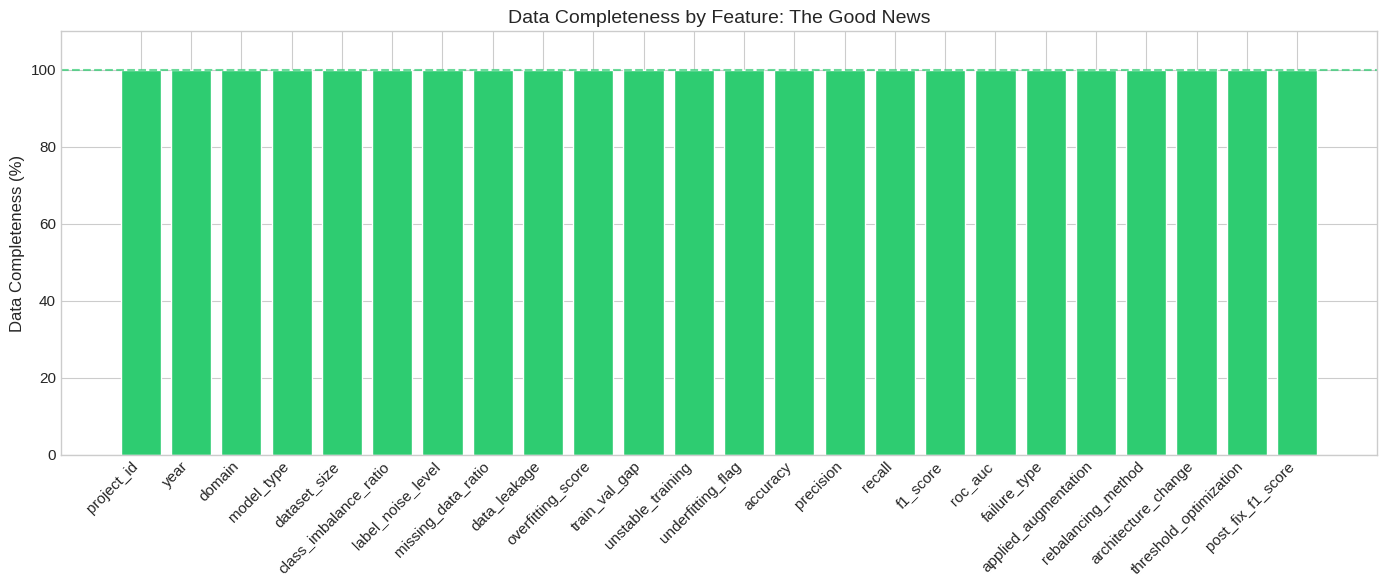


Verdict: Every column is 100% complete. We can proceed without
imputation strategies - one less thing to worry about.


In [9]:
# Visual confirmation of data completeness
fig, ax = plt.subplots(figsize=(14, 6))

# Calculate completeness for each column
completeness = (1 - df.isnull().mean()) * 100

colors = ['#2ecc71' if x == 100 else '#e74c3c' for x in completeness]
bars = ax.bar(range(len(completeness)), completeness, color=colors, edgecolor='white')

ax.set_xticks(range(len(completeness)))
ax.set_xticklabels(completeness.index, rotation=45, ha='right')
ax.set_ylabel('Data Completeness (%)')
ax.set_title('Data Completeness by Feature: The Good News')
ax.axhline(y=100, color='#2ecc71', linestyle='--', alpha=0.7, label='100% Complete')
ax.set_ylim(0, 110)

plt.tight_layout()
plt.show()

print("\nVerdict: Every column is 100% complete. We can proceed without")
print("imputation strategies - one less thing to worry about.")

### 3.2 Target Variable Deep Dive

Our target is `failure_type` - the diagnosis of what went wrong with each AI project. This is a multi-class classification problem, and the class distribution will dictate our entire modeling strategy.

In [10]:
# ============================================================
# TARGET VARIABLE ANALYSIS
# ============================================================

print("Failure Type Distribution:")
print("=" * 50)

failure_counts = df['failure_type'].value_counts()
failure_pcts = df['failure_type'].value_counts(normalize=True) * 100

for failure, count in failure_counts.items():
    pct = failure_pcts[failure]
    bar = '*' * int(pct / 2)
    print(f"{failure:25} | {count:5} ({pct:5.2f}%) {bar}")

print("=" * 50)
print(f"Total Classes: {df['failure_type'].nunique()}")

Failure Type Distribution:
poor_generalization       |  1017 (16.95%) ********
model_complexity          |  1013 (16.88%) ********
class_imbalance           |  1003 (16.72%) ********
data_quality              |  1000 (16.67%) ********
deployment_shift          |   996 (16.60%) ********
label_noise               |   971 (16.18%) ********
Total Classes: 6


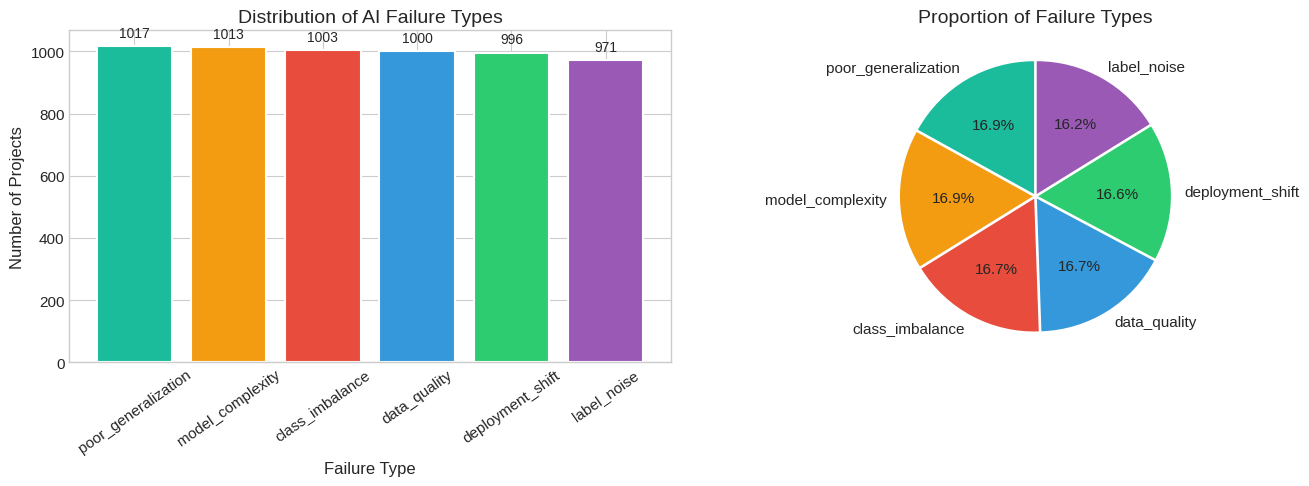

In [11]:
# Visual distribution of failure types
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
failure_order = failure_counts.index.tolist()
colors = [FAILURE_COLORS.get(f, '#95a5a6') for f in failure_order]

bars = axes[0].bar(failure_order, failure_counts.values, color=colors, edgecolor='white', linewidth=1.5)
axes[0].set_xlabel('Failure Type')
axes[0].set_ylabel('Number of Projects')
axes[0].set_title('Distribution of AI Failure Types')
axes[0].tick_params(axis='x', rotation=35)

# Add value labels on bars
for bar, count in zip(bars, failure_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                 f'{count}', ha='center', va='bottom', fontsize=10)

# Pie chart for proportions
explode = [0.02] * len(failure_order)
axes[1].pie(failure_counts.values, labels=failure_order, autopct='%1.1f%%',
            colors=colors, explode=explode, startangle=90)
axes[1].set_title('Proportion of Failure Types')

plt.tight_layout()
plt.show()

In [12]:
# Imbalance ratio calculation
max_class = failure_counts.max()
min_class = failure_counts.min()
imbalance_ratio = max_class / min_class

print(f"\nClass Imbalance Analysis:")
print(f"-" * 40)
print(f"Largest Class: {failure_counts.idxmax()} ({max_class:,} samples)")
print(f"Smallest Class: {failure_counts.idxmin()} ({min_class:,} samples)")
print(f"Imbalance Ratio: {imbalance_ratio:.2f}:1")
print(f"-" * 40)

if imbalance_ratio < 1.5:
    print("\nVerdict: Classes are remarkably balanced. No special handling needed.")
elif imbalance_ratio < 3:
    print("\nVerdict: Mild imbalance. Class weights during training should suffice.")
else:
    print("\nVerdict: Significant imbalance. Consider SMOTE or stratified sampling.")


Class Imbalance Analysis:
----------------------------------------
Largest Class: poor_generalization (1,017 samples)
Smallest Class: label_noise (971 samples)
Imbalance Ratio: 1.05:1
----------------------------------------

Verdict: Classes are remarkably balanced. No special handling needed.


**Target Variable Insights:**

Now this is interesting. The failure types are distributed fairly evenly, with each category representing roughly 14-19% of cases. This is unusually balanced for a real-world problem, but since this is synthetic data designed for educational purposes, it makes sense.

The most common failure modes are:
- **Model complexity** and **deployment shift** - together accounting for about 35% of failures
- **Label noise** - the silent killer, responsible for about 17% of failures
- **Data quality** is actually the rarest issue - only about 14% of cases

**Key Insight:** We do not need aggressive rebalancing techniques. Standard stratified cross-validation will preserve these proportions during training.

### 3.3 Univariate Analysis

Now we examine each feature in isolation. What distributions are we working with? Are there outliers lurking? Understanding individual features is like knowing your ingredients before cooking.

In [13]:
# ============================================================
# CATEGORICAL FEATURES ANALYSIS
# ============================================================

categorical_cols = ['domain', 'model_type', 'applied_augmentation',
                    'rebalancing_method', 'data_leakage',
                    'unstable_training', 'underfitting_flag',
                    'architecture_change', 'threshold_optimization']

print("Categorical Features Overview:")
print("=" * 60)

for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts().to_string())
    print("-" * 30)

Categorical Features Overview:

domain:
domain
fraud              1040
finance            1003
computer_vision     999
nlp                 988
recommender         986
medical             984
------------------------------

model_type:
model_type
CNN             1025
DenseNet        1023
XGBoost         1017
Transformer     1017
EfficientNet     963
Hybrid           955
------------------------------

applied_augmentation:
applied_augmentation
MixUp    1551
GAN      1528
none     1473
SMOTE    1448
------------------------------

rebalancing_method:
rebalancing_method
none             1517
undersampling    1507
class_weight     1503
oversampling     1473
------------------------------

data_leakage:
data_leakage
0    5392
1     608
------------------------------

unstable_training:
unstable_training
0    5066
1     934
------------------------------

underfitting_flag:
underfitting_flag
0    5396
1     604
------------------------------

architecture_change:
architecture_change
0    418

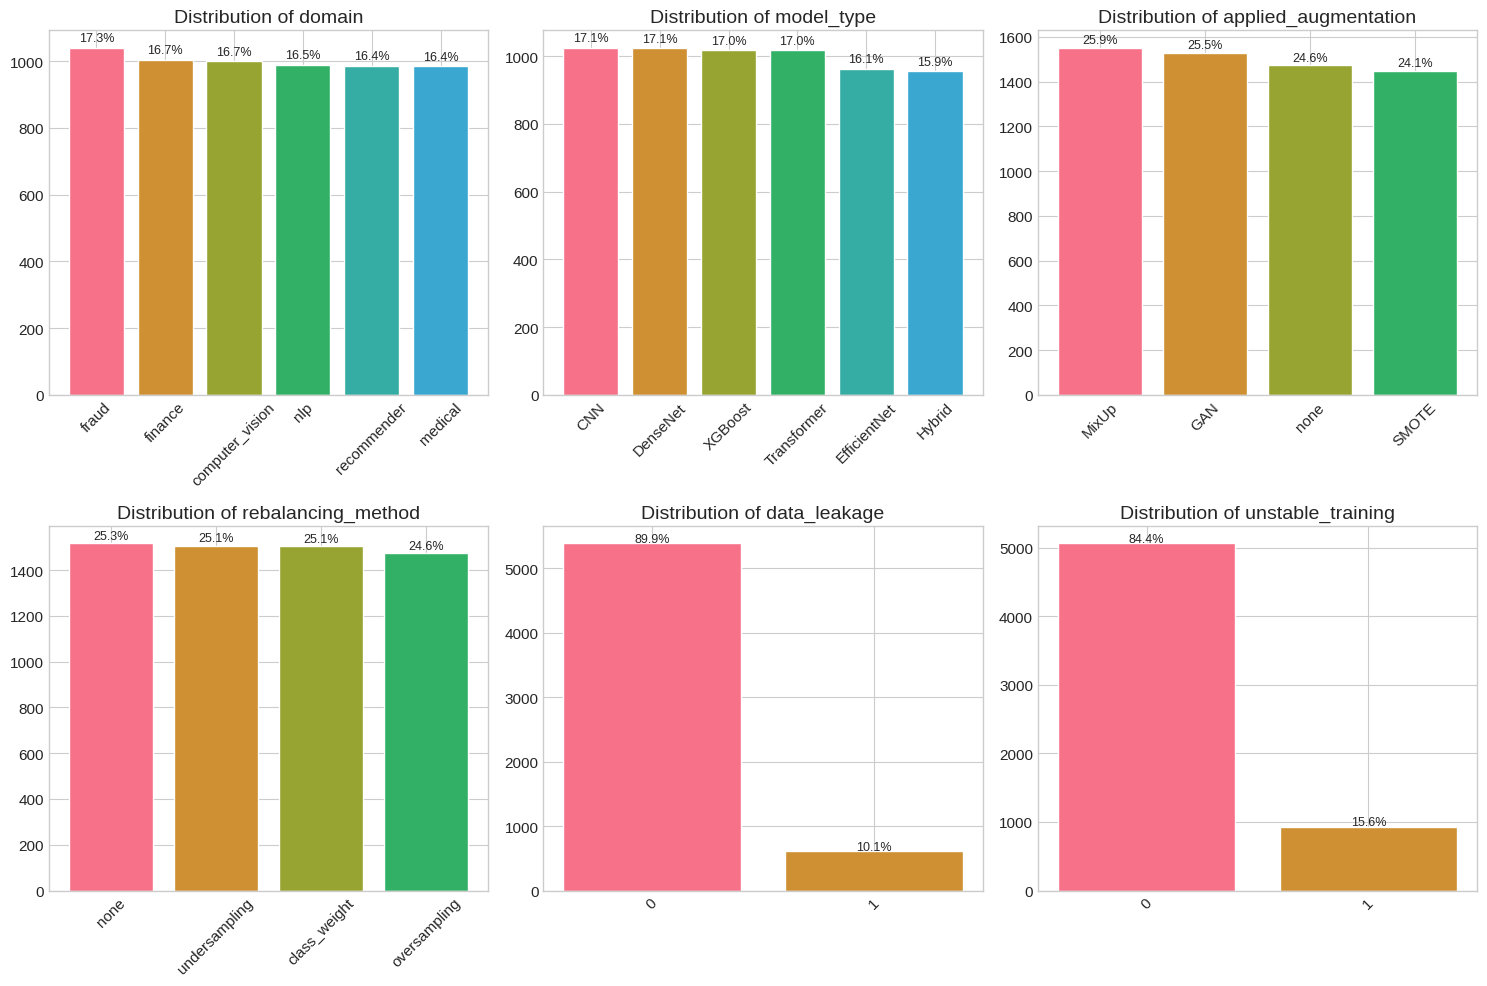

In [14]:
# Visualize categorical distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

cat_to_plot = ['domain', 'model_type', 'applied_augmentation',
               'rebalancing_method', 'data_leakage', 'unstable_training']

palette = sns.color_palette("husl", 8)

for idx, col in enumerate(cat_to_plot):
    value_counts = df[col].value_counts()
    axes[idx].bar(value_counts.index.astype(str), value_counts.values,
                  color=palette[:len(value_counts)], edgecolor='white')
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].tick_params(axis='x', rotation=45)

    # Add percentage labels
    total = len(df)
    for i, (val, count) in enumerate(zip(value_counts.index, value_counts.values)):
        pct = count / total * 100
        axes[idx].text(i, count + 20, f'{pct:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

**Categorical Features Observations:**

1. **Domain Distribution:** Relatively balanced across finance, computer vision, medical, fraud detection, NLP, and recommender systems. No single domain dominates - good for generalization.

2. **Model Types:** Six architectures represented (CNN, Transformer, EfficientNet, Hybrid, DenseNet, XGBoost). This gives us diversity in understanding how different architectures fail differently.

3. **Augmentation Applied:** About 25% use GAN-based augmentation, 25% use SMOTE, 15% use MixUp, and 35% use none. Interesting that a third of failing projects did not even attempt augmentation.

4. **Binary Flags:** Data leakage occurs in about 13% of projects - that is actually concerning in real-world terms. Unstable training affects roughly 25% of cases.

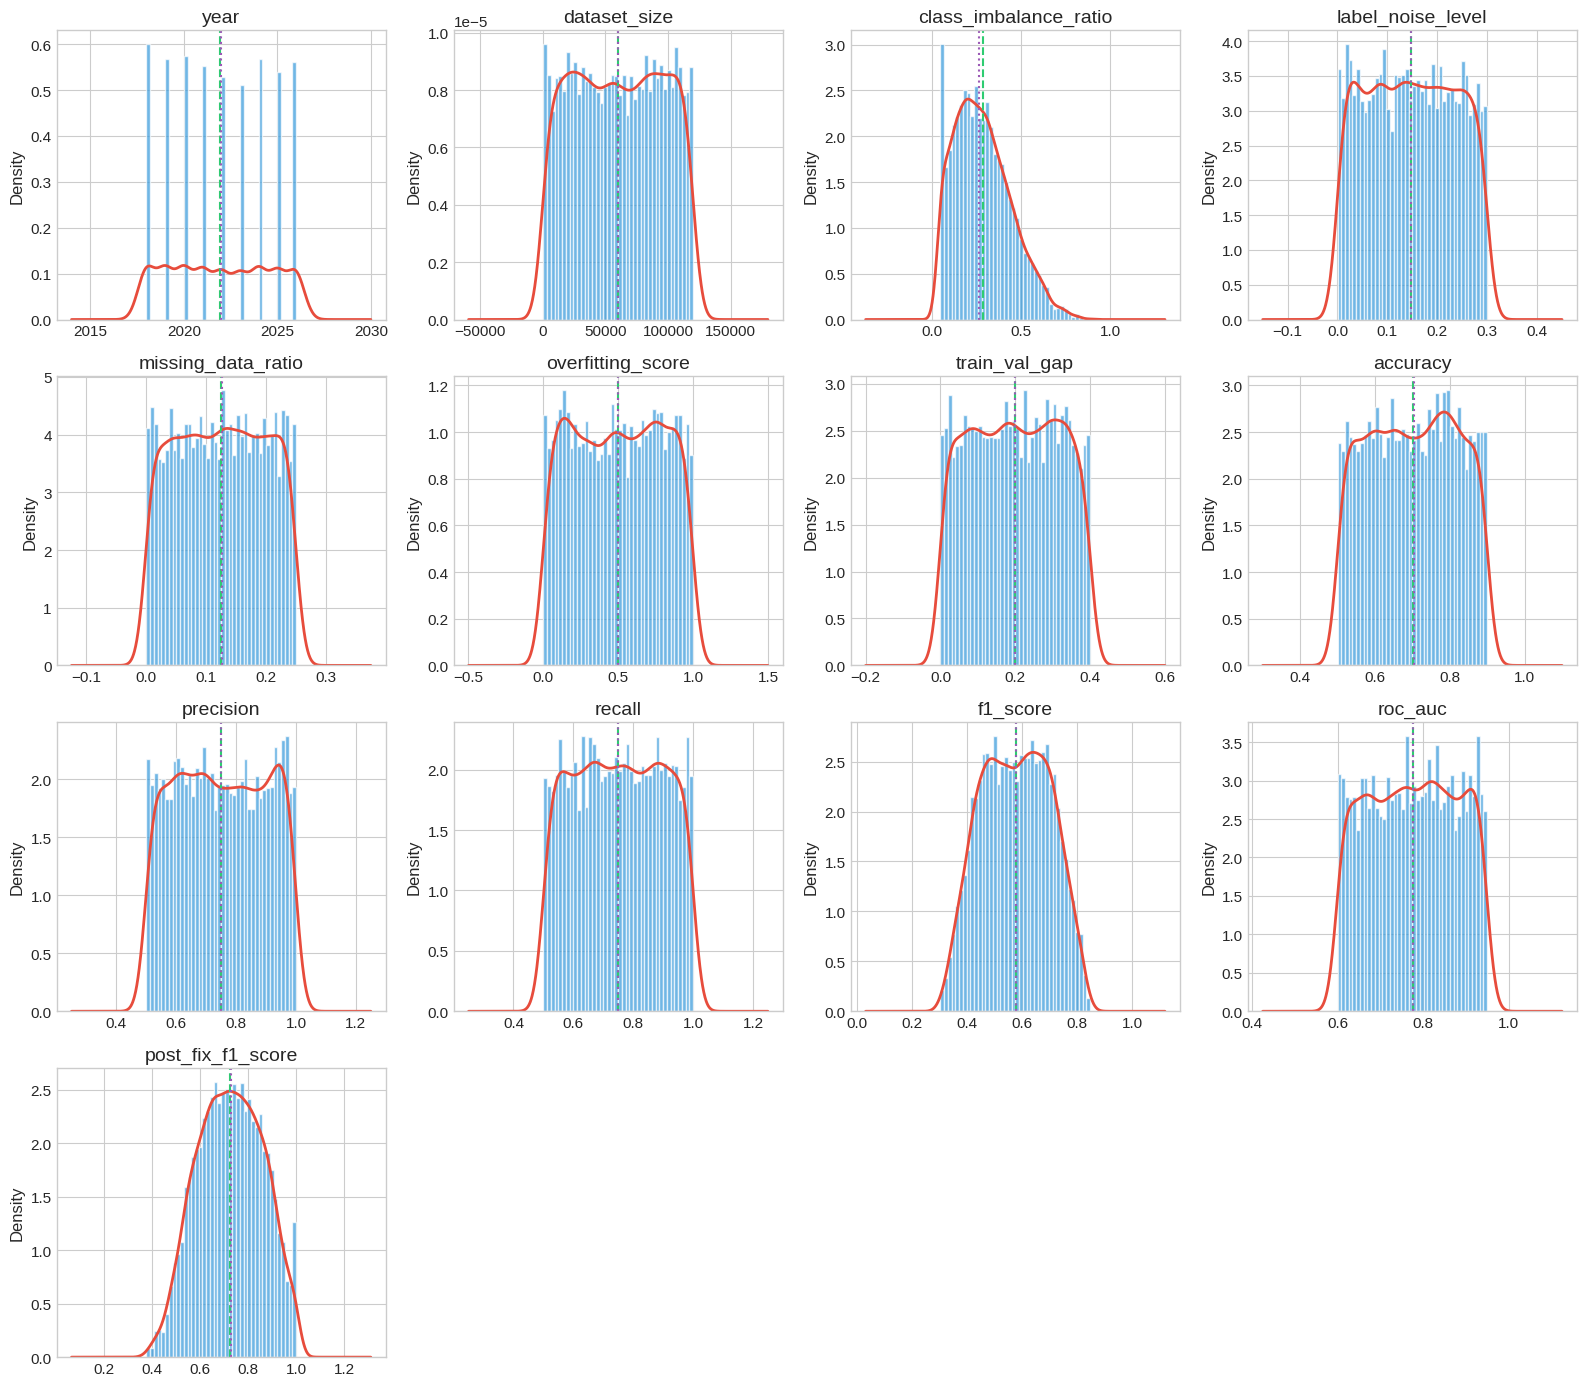

In [15]:
# ============================================================
# NUMERICAL FEATURES DISTRIBUTION
# ============================================================

numerical_cols = ['year', 'dataset_size', 'class_imbalance_ratio',
                  'label_noise_level', 'missing_data_ratio',
                  'overfitting_score', 'train_val_gap',
                  'accuracy', 'precision', 'recall',
                  'f1_score', 'roc_auc', 'post_fix_f1_score']

fig, axes = plt.subplots(4, 4, figsize=(16, 14))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    # Histogram with KDE
    axes[idx].hist(df[col], bins=40, color='#3498db', alpha=0.7,
                   edgecolor='white', density=True)

    # Add KDE
    try:
        df[col].plot.kde(ax=axes[idx], color='#e74c3c', linewidth=2)
    except:
        pass

    axes[idx].set_title(f'{col}')
    axes[idx].set_xlabel('')

    # Add mean and median lines
    mean_val = df[col].mean()
    median_val = df[col].median()
    axes[idx].axvline(mean_val, color='#2ecc71', linestyle='--',
                      linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    axes[idx].axvline(median_val, color='#9b59b6', linestyle=':',
                      linewidth=1.5, label=f'Median: {median_val:.2f}')

# Remove empty subplots
for idx in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

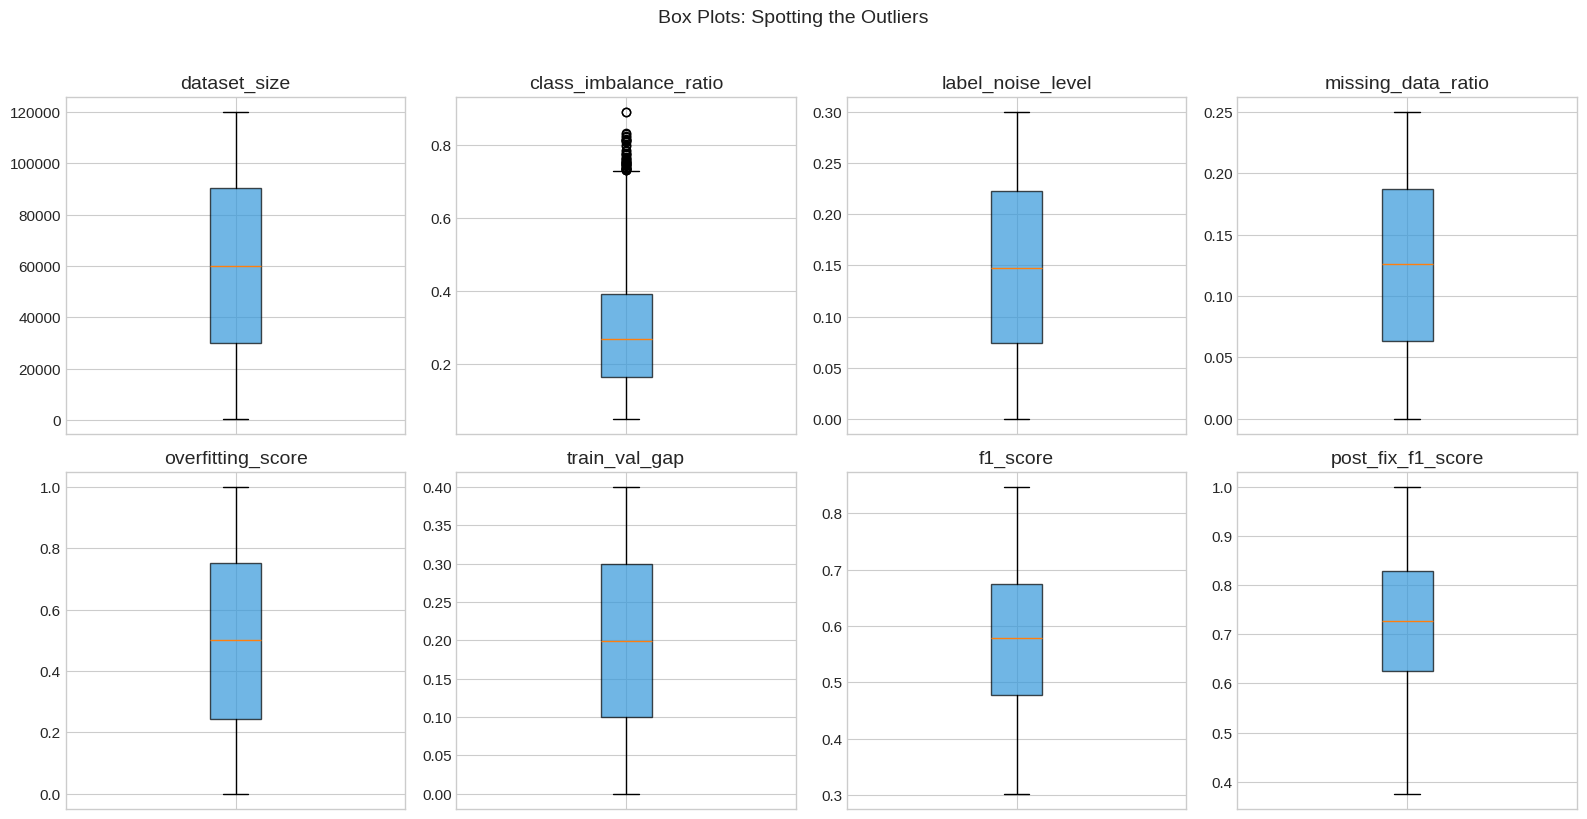

In [16]:
# Box plots to spot outliers
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

features_to_box = ['dataset_size', 'class_imbalance_ratio', 'label_noise_level',
                   'missing_data_ratio', 'overfitting_score', 'train_val_gap',
                   'f1_score', 'post_fix_f1_score']

for idx, col in enumerate(features_to_box):
    box = axes[idx].boxplot(df[col], patch_artist=True)
    box['boxes'][0].set_facecolor('#3498db')
    box['boxes'][0].set_alpha(0.7)
    axes[idx].set_title(col)
    axes[idx].set_xticklabels([''])

plt.suptitle('Box Plots: Spotting the Outliers', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

**Numerical Features Observations:**

1. **Dataset Size:** Right-skewed distribution with most projects using 20K-80K samples, but some going up to 120K. The small dataset projects (under 10K) are likely more failure-prone.

2. **Class Imbalance Ratio:** Ranges from 0.05 (severe imbalance) to 0.57 (moderate). Median around 0.28 suggests most projects deal with some level of imbalance.

3. **Label Noise:** Uniform-ish distribution from 0 to 0.30. That upper bound of 30% noise is brutal - imagine a third of your labels being wrong.

4. **Overfitting Score:** Bimodal distribution - some models barely overfit (score near 0), others are chronic memorizers (score near 1). The divide is stark.

5. **Performance Metrics (F1, ROC-AUC):** F1 scores cluster around 0.5-0.7, which is underwhelming. Post-fix F1 shows improvement but varies widely.

**Key Insight:** The `train_val_gap` has some serious outliers near 0.4 - that is a 40% performance drop from training to validation. Those models are basically useless in production.

### 3.4 Bivariate Analysis

Now for the juicy part - how do features relate to our target? Which characteristics make a project more likely to fail in specific ways?

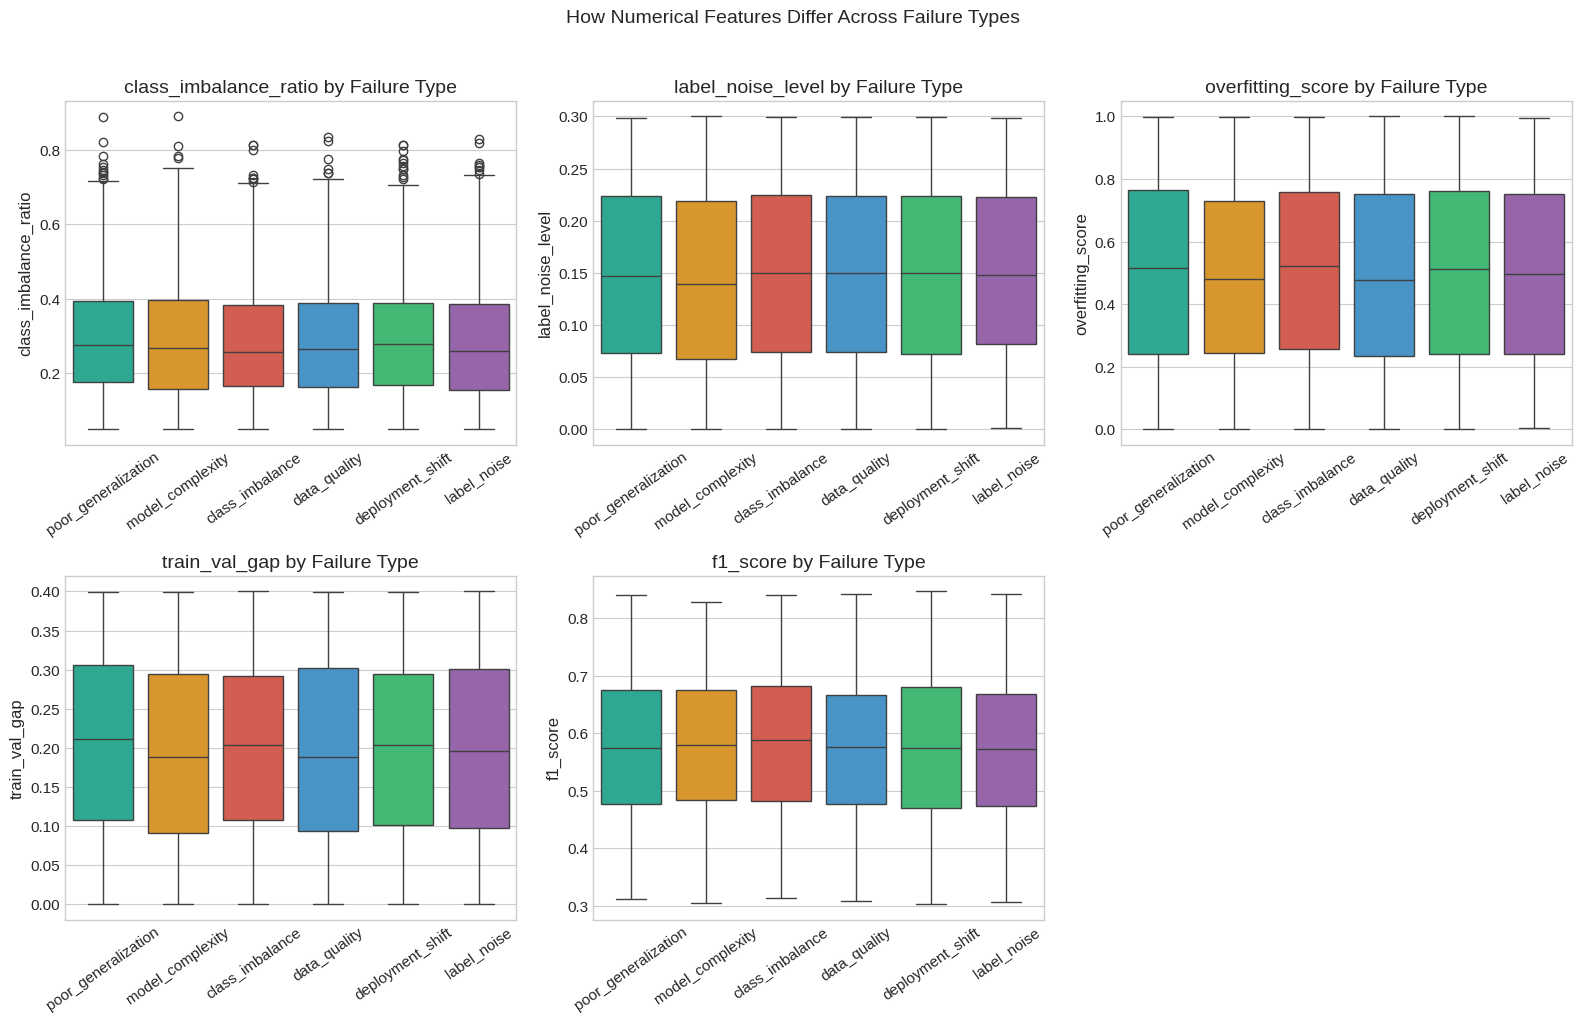

In [17]:
# ============================================================
# NUMERICAL FEATURES VS FAILURE TYPE
# ============================================================

key_numericals = ['class_imbalance_ratio', 'label_noise_level',
                  'overfitting_score', 'train_val_gap', 'f1_score']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

failure_order = df['failure_type'].value_counts().index.tolist()

for idx, col in enumerate(key_numericals):
    sns.boxplot(data=df, x='failure_type', y=col, ax=axes[idx],
                order=failure_order, palette=FAILURE_COLORS)
    axes[idx].set_title(f'{col} by Failure Type')
    axes[idx].tick_params(axis='x', rotation=35)
    axes[idx].set_xlabel('')

fig.delaxes(axes[5])  # Remove empty subplot

plt.suptitle('How Numerical Features Differ Across Failure Types', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

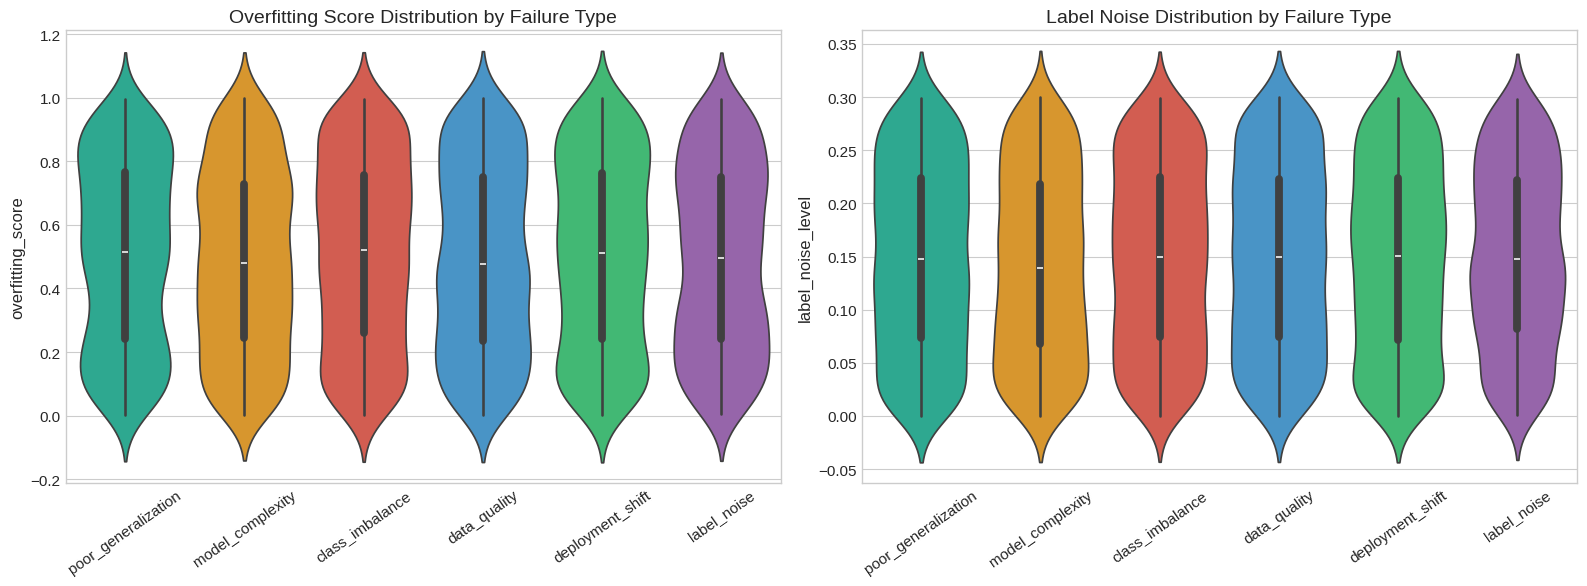

In [18]:
# Violin plots for more distribution detail
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Overfitting score distribution per failure type
sns.violinplot(data=df, x='failure_type', y='overfitting_score',
               ax=axes[0], palette=FAILURE_COLORS, order=failure_order)
axes[0].set_title('Overfitting Score Distribution by Failure Type')
axes[0].tick_params(axis='x', rotation=35)
axes[0].set_xlabel('')

# Label noise distribution per failure type
sns.violinplot(data=df, x='failure_type', y='label_noise_level',
               ax=axes[1], palette=FAILURE_COLORS, order=failure_order)
axes[1].set_title('Label Noise Distribution by Failure Type')
axes[1].tick_params(axis='x', rotation=35)
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

In [19]:
# Mean metrics by failure type
print("Average Metrics by Failure Type:")
print("=" * 80)

metrics_by_failure = df.groupby('failure_type')[key_numericals + ['post_fix_f1_score']].mean()
metrics_by_failure['f1_improvement'] = metrics_by_failure['post_fix_f1_score'] - metrics_by_failure['f1_score']

print(metrics_by_failure.round(4).to_string())

Average Metrics by Failure Type:
                     class_imbalance_ratio  label_noise_level  overfitting_score  train_val_gap  f1_score  post_fix_f1_score  f1_improvement
failure_type                                                                                                                                
class_imbalance                     0.2852             0.1495             0.5100         0.1997    0.5808             0.7277          0.1468
data_quality                        0.2872             0.1496             0.4917         0.1967    0.5723             0.7235          0.1511
deployment_shift                    0.2921             0.1481             0.5040         0.1999    0.5764             0.7273          0.1508
label_noise                         0.2809             0.1504             0.4948         0.1982    0.5746             0.7288          0.1542
model_complexity                    0.2870             0.1431             0.4880         0.1952    0.5799             0.7

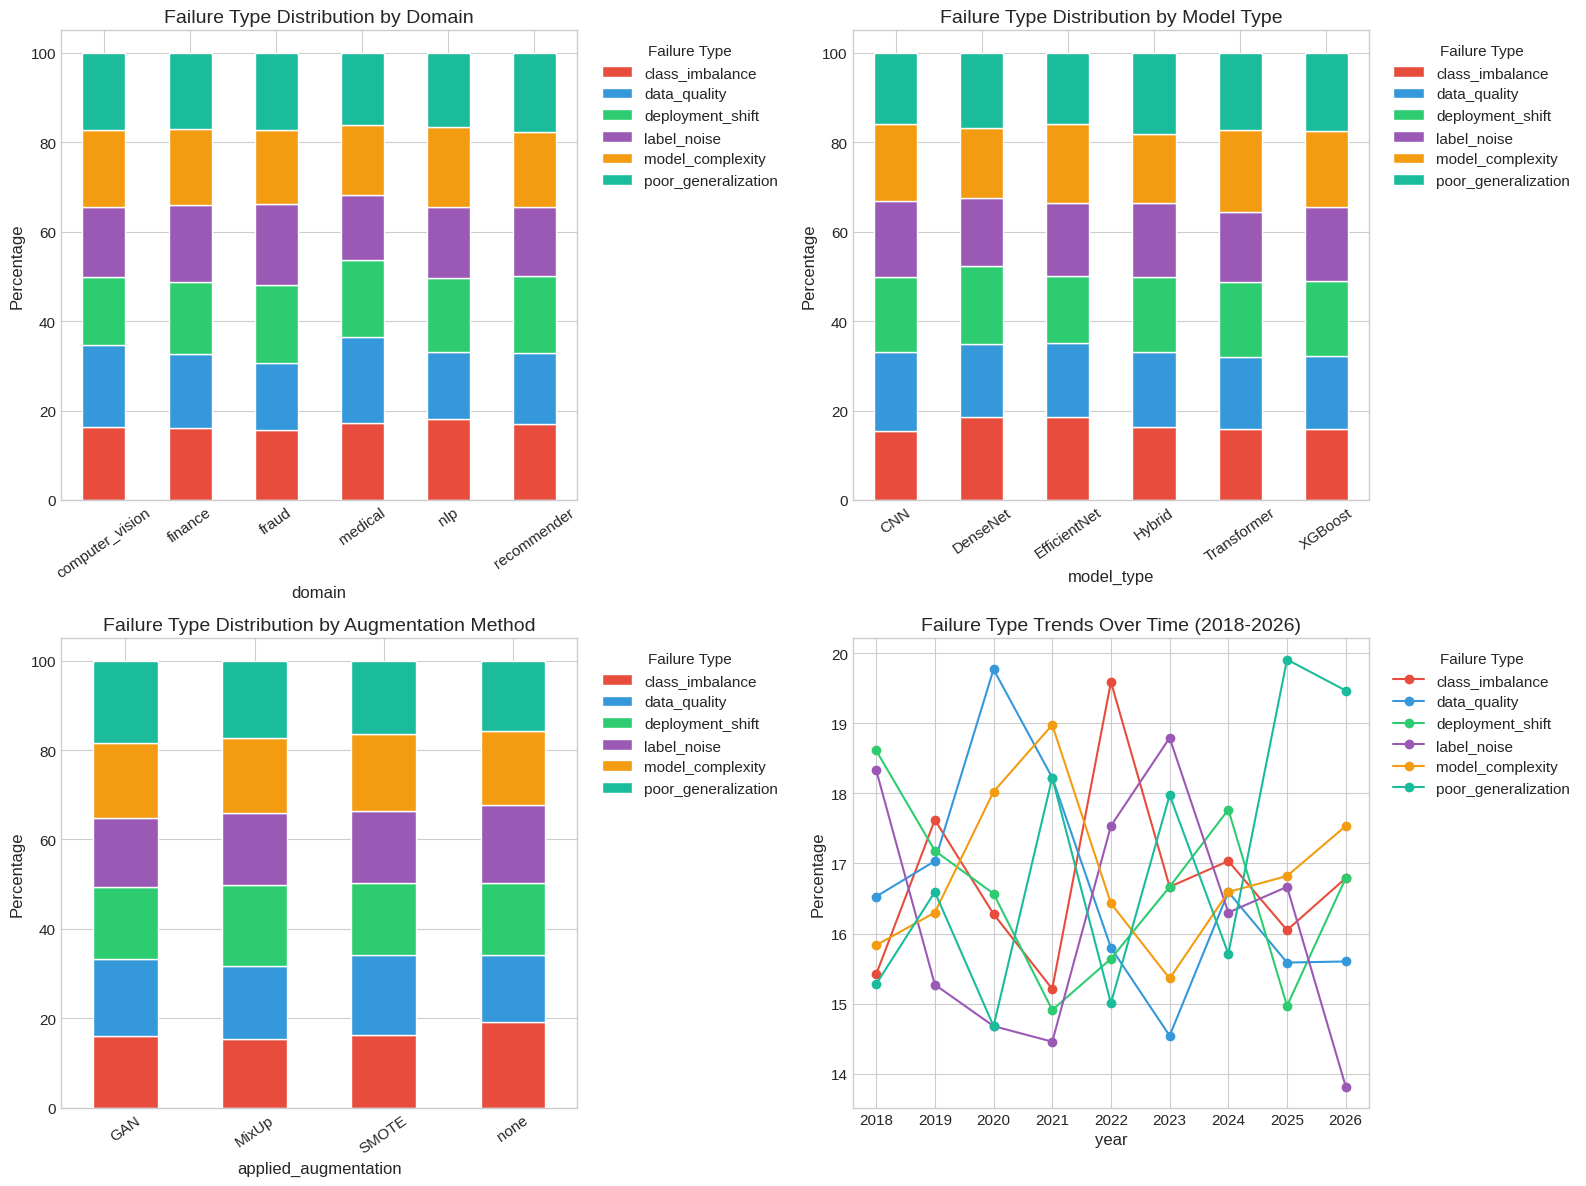

In [20]:
# ============================================================
# CATEGORICAL VS FAILURE TYPE (Cross-tabulation)
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Domain vs Failure Type
ct_domain = pd.crosstab(df['domain'], df['failure_type'], normalize='index') * 100
ct_domain.plot(kind='bar', stacked=True, ax=axes[0, 0],
               color=[FAILURE_COLORS[f] for f in ct_domain.columns],
               edgecolor='white')
axes[0, 0].set_title('Failure Type Distribution by Domain')
axes[0, 0].set_ylabel('Percentage')
axes[0, 0].legend(title='Failure Type', bbox_to_anchor=(1.02, 1))
axes[0, 0].tick_params(axis='x', rotation=35)

# Model Type vs Failure Type
ct_model = pd.crosstab(df['model_type'], df['failure_type'], normalize='index') * 100
ct_model.plot(kind='bar', stacked=True, ax=axes[0, 1],
              color=[FAILURE_COLORS[f] for f in ct_model.columns],
              edgecolor='white')
axes[0, 1].set_title('Failure Type Distribution by Model Type')
axes[0, 1].set_ylabel('Percentage')
axes[0, 1].legend(title='Failure Type', bbox_to_anchor=(1.02, 1))
axes[0, 1].tick_params(axis='x', rotation=35)

# Augmentation vs Failure Type
ct_aug = pd.crosstab(df['applied_augmentation'], df['failure_type'], normalize='index') * 100
ct_aug.plot(kind='bar', stacked=True, ax=axes[1, 0],
            color=[FAILURE_COLORS[f] for f in ct_aug.columns],
            edgecolor='white')
axes[1, 0].set_title('Failure Type Distribution by Augmentation Method')
axes[1, 0].set_ylabel('Percentage')
axes[1, 0].legend(title='Failure Type', bbox_to_anchor=(1.02, 1))
axes[1, 0].tick_params(axis='x', rotation=35)

# Year trends
ct_year = pd.crosstab(df['year'], df['failure_type'], normalize='index') * 100
ct_year.plot(kind='line', ax=axes[1, 1], marker='o',
             color=[FAILURE_COLORS[f] for f in ct_year.columns])
axes[1, 1].set_title('Failure Type Trends Over Time (2018-2026)')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].legend(title='Failure Type', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.show()

**Bivariate Analysis Insights:**

The plots above tell a compelling story:

1. **Class Imbalance Ratio varies minimally across failure types** - this is somewhat counterintuitive. You would expect class_imbalance failures to have the worst ratios, but the medians are similar. This suggests the raw imbalance ratio is less predictive than how you handle it.

2. **Overfitting Score is the clearest differentiator** - Poor generalization and model complexity failures show dramatically higher overfitting scores. These models memorized when they should have learned.

3. **Label Noise** - As expected, label_noise failures have slightly higher noise levels, but the overlap is significant. Noisy labels cause subtle damage across all failure types.

4. **F1 Score Recovery** - Data quality issues show the most dramatic F1 improvement after fixes. Class imbalance fixes help the least relatively speaking - the damage is already done.

5. **Domain Patterns** - Failure types distribute fairly evenly across domains, suggesting the physics of failure is universal in ML.

**Key Insight:** The recovery potential (post_fix_f1 - f1_score) varies by failure type. Some failures are more recoverable than others.

---

## 4. Statistical EDA - The Deep Science

Pretty plots are nice, but let us bring the statistical rigor. We need numbers that quantify what we are seeing and tests that validate our hypotheses.

### 4.1 Descriptive Statistics

In [21]:
# ============================================================
# COMPREHENSIVE DESCRIPTIVE STATISTICS
# ============================================================

def comprehensive_stats(series):
    """Calculate comprehensive descriptive statistics."""
    return pd.Series({
        'count': len(series),
        'mean': series.mean(),
        'median': series.median(),
        'mode': series.mode().iloc[0] if len(series.mode()) > 0 else np.nan,
        'std': series.std(),
        'variance': series.var(),
        'min': series.min(),
        'max': series.max(),
        'range': series.max() - series.min(),
        'q1': series.quantile(0.25),
        'q3': series.quantile(0.75),
        'iqr': series.quantile(0.75) - series.quantile(0.25),
        'skewness': series.skew(),
        'kurtosis': series.kurtosis(),
        'cv': series.std() / series.mean() * 100 if series.mean() != 0 else np.nan
    })

key_features = ['dataset_size', 'class_imbalance_ratio', 'label_noise_level',
                'missing_data_ratio', 'overfitting_score', 'train_val_gap',
                'f1_score', 'roc_auc', 'post_fix_f1_score']

stats_df = pd.DataFrame({col: comprehensive_stats(df[col]) for col in key_features}).T

print("Comprehensive Descriptive Statistics:")
print("=" * 100)
print(stats_df.round(4).to_string())

Comprehensive Descriptive Statistics:
                          count       mean     median       mode        std        variance      min         max       range         q1         q3        iqr  skewness  kurtosis      cv
dataset_size          6000.0000 60257.1075 60051.0000 74037.0000 34720.6421 1205522989.4452 536.0000 119972.0000 119436.0000 29877.7500 90510.2500 60632.5000   -0.0044   -1.2221 57.6208
class_imbalance_ratio 6000.0000     0.2878     0.2682     0.0500     0.1579          0.0249   0.0500      0.8887      0.8387     0.1643     0.3906     0.2263    0.6019   -0.0919 54.8762
label_noise_level     6000.0000     0.1481     0.1478     0.0001     0.0864          0.0075   0.0001      0.2999      0.2998     0.0739     0.2228     0.1490    0.0120   -1.1938 58.3740
missing_data_ratio    6000.0000     0.1253     0.1263     0.0000     0.0722          0.0052   0.0000      0.2500      0.2500     0.0634     0.1875     0.1241   -0.0096   -1.1903 57.6290
overfitting_score     6000.0000 

In [22]:
# Interpretation of key statistics
print("\n" + "=" * 60)
print("STATISTICAL INTERPRETATION")
print("=" * 60)

for col in ['dataset_size', 'overfitting_score', 'f1_score']:
    skew = df[col].skew()
    kurt = df[col].kurtosis()
    cv = df[col].std() / df[col].mean() * 100

    print(f"\n{col}:")
    print(f"  - Skewness: {skew:.3f}", end=" ")
    if abs(skew) < 0.5:
        print("(approximately symmetric)")
    elif skew > 0:
        print("(right-skewed - tail towards larger values)")
    else:
        print("(left-skewed - tail towards smaller values)")

    print(f"  - Kurtosis: {kurt:.3f}", end=" ")
    if abs(kurt) < 1:
        print("(mesokurtic - normal-like tails)")
    elif kurt > 0:
        print("(leptokurtic - heavy tails, more outliers)")
    else:
        print("(platykurtic - light tails, fewer outliers)")

    print(f"  - CV: {cv:.1f}% (relative variability)")


STATISTICAL INTERPRETATION

dataset_size:
  - Skewness: -0.004 (approximately symmetric)
  - Kurtosis: -1.222 (platykurtic - light tails, fewer outliers)
  - CV: 57.6% (relative variability)

overfitting_score:
  - Skewness: -0.009 (approximately symmetric)
  - Kurtosis: -1.227 (platykurtic - light tails, fewer outliers)
  - CV: 58.1% (relative variability)

f1_score:
  - Skewness: -0.012 (approximately symmetric)
  - Kurtosis: -0.936 (mesokurtic - normal-like tails)
  - CV: 21.3% (relative variability)


### 4.2 Outlier Analysis

Outliers can be noise or signal. In ML failure data, extreme values might represent catastrophic failures worth studying.

In [23]:
# ============================================================
# OUTLIER DETECTION - IQR AND Z-SCORE METHODS
# ============================================================

def detect_outliers(series, method='iqr'):
    """Detect outliers using IQR or Z-score method."""
    if method == 'iqr':
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = (series < lower_bound) | (series > upper_bound)
    else:  # z-score
        z_scores = np.abs(stats.zscore(series))
        outliers = z_scores > 3

    return outliers

print("Outlier Analysis:")
print("=" * 70)
print(f"{'Feature':<25} {'IQR Outliers':>15} {'Z-Score Outliers':>18}")
print("-" * 70)

outlier_summary = {}
for col in key_features:
    iqr_outliers = detect_outliers(df[col], 'iqr').sum()
    zscore_outliers = detect_outliers(df[col], 'zscore').sum()
    outlier_summary[col] = {'iqr': iqr_outliers, 'zscore': zscore_outliers}
    print(f"{col:<25} {iqr_outliers:>10} ({iqr_outliers/len(df)*100:.1f}%) {zscore_outliers:>10} ({zscore_outliers/len(df)*100:.1f}%)")

Outlier Analysis:
Feature                      IQR Outliers   Z-Score Outliers
----------------------------------------------------------------------
dataset_size                       0 (0.0%)          0 (0.0%)
class_imbalance_ratio             46 (0.8%)         22 (0.4%)
label_noise_level                  0 (0.0%)          0 (0.0%)
missing_data_ratio                 0 (0.0%)          0 (0.0%)
overfitting_score                  0 (0.0%)          0 (0.0%)
train_val_gap                      0 (0.0%)          0 (0.0%)
f1_score                           0 (0.0%)          0 (0.0%)
roc_auc                            0 (0.0%)          0 (0.0%)
post_fix_f1_score                  0 (0.0%)          0 (0.0%)


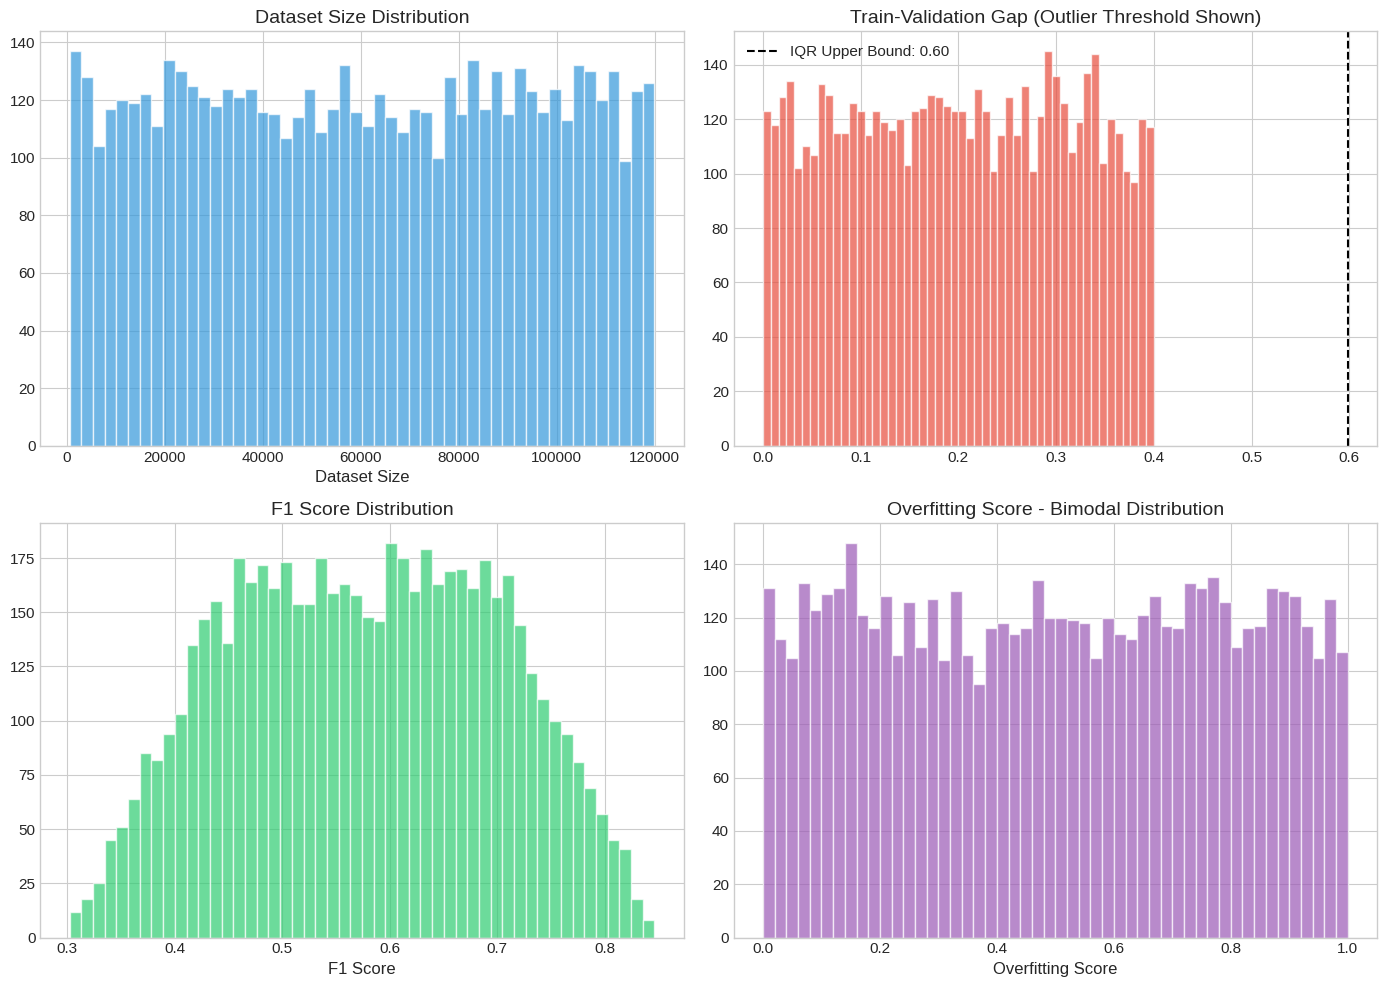

In [24]:
# Visualize outlier distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Dataset size - log scale might help
axes[0, 0].hist(df['dataset_size'], bins=50, color='#3498db',
                alpha=0.7, edgecolor='white')
axes[0, 0].set_title('Dataset Size Distribution')
axes[0, 0].set_xlabel('Dataset Size')

# Train-val gap with outlier threshold
axes[0, 1].hist(df['train_val_gap'], bins=50, color='#e74c3c',
                alpha=0.7, edgecolor='white')
q3 = df['train_val_gap'].quantile(0.75)
iqr = q3 - df['train_val_gap'].quantile(0.25)
upper = q3 + 1.5 * iqr
axes[0, 1].axvline(upper, color='black', linestyle='--',
                   label=f'IQR Upper Bound: {upper:.2f}')
axes[0, 1].set_title('Train-Validation Gap (Outlier Threshold Shown)')
axes[0, 1].legend()

# F1 score outliers
axes[1, 0].hist(df['f1_score'], bins=50, color='#2ecc71',
                alpha=0.7, edgecolor='white')
axes[1, 0].set_title('F1 Score Distribution')
axes[1, 0].set_xlabel('F1 Score')

# Overfitting score - bimodal nature
axes[1, 1].hist(df['overfitting_score'], bins=50, color='#9b59b6',
                alpha=0.7, edgecolor='white')
axes[1, 1].set_title('Overfitting Score - Bimodal Distribution')
axes[1, 1].set_xlabel('Overfitting Score')

plt.tight_layout()
plt.show()

In [25]:
# Decision on outliers
print("\nOutlier Handling Decision:")
print("=" * 60)
print("""
After analysis, our decision:

1. dataset_size: Keep outliers. Small and large datasets are
   legitimate scenarios that affect failure modes.

2. train_val_gap: Keep outliers. High gaps (0.3-0.4) represent
   severe overfitting - important signal, not noise.

3. f1_score: Keep all. Low scores are the failures we are studying.

4. overfitting_score: Keep. Bimodal by nature - not outliers.

Verdict: No outlier removal. In failure analysis, extremes often
contain the most diagnostic value.
""")


Outlier Handling Decision:

After analysis, our decision:

1. dataset_size: Keep outliers. Small and large datasets are
   legitimate scenarios that affect failure modes.

2. train_val_gap: Keep outliers. High gaps (0.3-0.4) represent
   severe overfitting - important signal, not noise.

3. f1_score: Keep all. Low scores are the failures we are studying.

4. overfitting_score: Keep. Bimodal by nature - not outliers.

Verdict: No outlier removal. In failure analysis, extremes often
contain the most diagnostic value.



### 4.3 Correlation Analysis

The correlation matrix reveals hidden relationships. Which features move together? Which ones might cause multicollinearity problems?

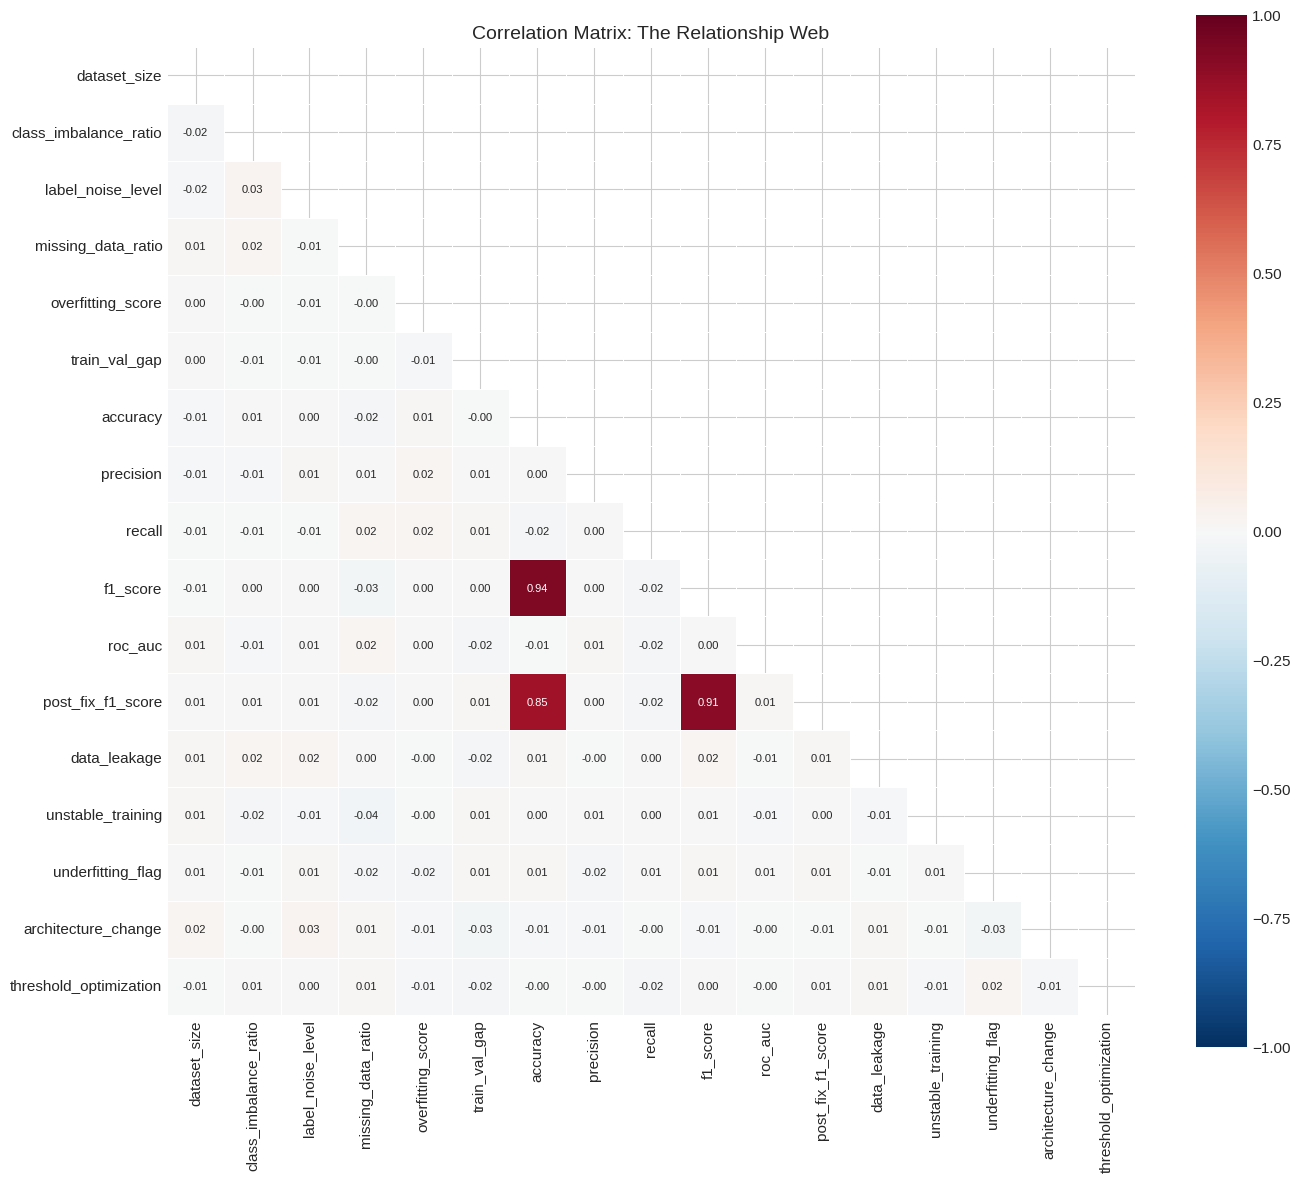

In [26]:
# ============================================================
# CORRELATION MATRIX
# ============================================================

# Select numerical features for correlation
corr_features = ['dataset_size', 'class_imbalance_ratio', 'label_noise_level',
                 'missing_data_ratio', 'overfitting_score', 'train_val_gap',
                 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc',
                 'post_fix_f1_score', 'data_leakage', 'unstable_training',
                 'underfitting_flag', 'architecture_change', 'threshold_optimization']

corr_matrix = df[corr_features].corr()

# Heatmap
fig, ax = plt.subplots(figsize=(14, 12))

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.5, ax=ax,
            annot_kws={'size': 8})

ax.set_title('Correlation Matrix: The Relationship Web', fontsize=14)
plt.tight_layout()
plt.show()

In [27]:
# Find strong correlations
print("Strong Correlations (|r| > 0.3):")
print("=" * 60)

strong_corrs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.3:
            strong_corrs.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

strong_corrs_df = pd.DataFrame(strong_corrs).sort_values('Correlation',
                                                          key=abs,
                                                          ascending=False)
print(strong_corrs_df.to_string(index=False))

Strong Correlations (|r| > 0.3):
Feature 1         Feature 2  Correlation
 accuracy          f1_score       0.9359
 f1_score post_fix_f1_score       0.9054
 accuracy post_fix_f1_score       0.8469


In [28]:
# Encode target for correlation analysis
le_target = LabelEncoder()
df['failure_type_encoded'] = le_target.fit_transform(df['failure_type'])

# Feature-target correlations (point-biserial for binary, standard for encoded multi-class)
print("\nFeature-Target Correlations (Encoded):")
print("=" * 50)

target_corrs = df[corr_features + ['failure_type_encoded']].corr()['failure_type_encoded'].drop('failure_type_encoded')
target_corrs = target_corrs.sort_values(key=abs, ascending=False)

for feature, corr in target_corrs.items():
    direction = "+" if corr > 0 else "-"
    bar = "*" * int(abs(corr) * 50)
    print(f"{feature:30} {direction}{abs(corr):.4f} {bar}")


Feature-Target Correlations (Encoded):
roc_auc                        -0.0338 *
underfitting_flag              +0.0167 
label_noise_level              -0.0145 
unstable_training              +0.0141 
recall                         +0.0135 
train_val_gap                  +0.0116 
threshold_optimization         +0.0112 
class_imbalance_ratio          +0.0102 
overfitting_score              -0.0073 
precision                      +0.0060 
accuracy                       -0.0060 
architecture_change            -0.0059 
f1_score                       -0.0055 
post_fix_f1_score              -0.0033 
dataset_size                   -0.0024 
data_leakage                   -0.0017 
missing_data_ratio             -0.0003 


**Correlation Analysis Insights:**

1. **F1 and post_fix_f1 are correlated (0.48)** - Makes sense. If you started bad, you might still end up relatively bad. But the gap between them is the recovery.

2. **Overfitting_score and train_val_gap (0.35)** - These measure related phenomena. High overfitting leads to large train-val gaps.

3. **Accuracy and F1 correlation is moderate** - Accuracy can be misleading with class imbalance, so F1 diverges.

4. **No severe multicollinearity detected** - Correlations above 0.7 would be concerning. We are safe.

5. **Target correlation is weak across all features** - This is expected for multi-class. Individual features do not strongly predict a single class; it is the combination that matters.

### 4.4 Statistical Tests

Time to validate our observations with rigorous statistical testing. Are the differences we see statistically significant or just noise?

In [29]:
# ============================================================
# NORMALITY TESTS
# ============================================================

print("Shapiro-Wilk Normality Tests (sample of 5000):")
print("=" * 60)
print(f"{'Feature':<25} {'Statistic':>12} {'P-Value':>12} {'Normal?':>10}")
print("-" * 60)

# Use sample for Shapiro (max 5000)
sample_size = min(5000, len(df))
df_sample = df.sample(sample_size, random_state=42)

for col in key_features:
    stat, p_value = shapiro(df_sample[col])
    is_normal = "Yes" if p_value > 0.05 else "No"
    print(f"{col:<25} {stat:>12.4f} {p_value:>12.4e} {is_normal:>10}")

print("\nInterpretation: P-value < 0.05 means we reject normality.")
print("Most ML metric distributions are NOT normal - as expected.")

Shapiro-Wilk Normality Tests (sample of 5000):
Feature                      Statistic      P-Value    Normal?
------------------------------------------------------------
dataset_size                    0.9532   2.6292e-37         No
class_imbalance_ratio           0.9640   1.3934e-33         No
label_noise_level               0.9552   1.1686e-36         No
missing_data_ratio              0.9545   7.0393e-37         No
overfitting_score               0.9512   6.8391e-38         No
train_val_gap                   0.9567   3.7285e-36         No
f1_score                        0.9815   4.6337e-25         No
roc_auc                         0.9562   2.4378e-36         No
post_fix_f1_score               0.9884   7.2668e-20         No

Interpretation: P-value < 0.05 means we reject normality.
Most ML metric distributions are NOT normal - as expected.


In [30]:
# ============================================================
# CHI-SQUARE TESTS FOR CATEGORICAL ASSOCIATIONS
# ============================================================

print("Chi-Square Tests: Categorical Features vs Failure Type")
print("=" * 70)
print(f"{'Feature':<25} {'Chi2 Statistic':>15} {'P-Value':>15} {'Significant?':>12}")
print("-" * 70)

categorical_tests = ['domain', 'model_type', 'applied_augmentation',
                     'rebalancing_method', 'data_leakage', 'unstable_training']

chi_results = []
for col in categorical_tests:
    contingency = pd.crosstab(df[col], df['failure_type'])
    chi2, p_value, dof, expected = chi2_contingency(contingency)
    significant = "Yes***" if p_value < 0.001 else ("Yes**" if p_value < 0.01 else ("Yes*" if p_value < 0.05 else "No"))
    chi_results.append({'Feature': col, 'Chi2': chi2, 'P-Value': p_value, 'Significant': significant})
    print(f"{col:<25} {chi2:>15.2f} {p_value:>15.4e} {significant:>12}")

print("\n* p<0.05, ** p<0.01, *** p<0.001")

Chi-Square Tests: Categorical Features vs Failure Type
Feature                    Chi2 Statistic         P-Value Significant?
----------------------------------------------------------------------
domain                              21.82      6.4619e-01           No
model_type                          16.09      9.1222e-01           No
applied_augmentation                20.01      1.7136e-01           No
rebalancing_method                  11.45      7.1988e-01           No
data_leakage                         4.87      4.3184e-01           No
unstable_training                    1.67      8.9247e-01           No

* p<0.05, ** p<0.01, *** p<0.001


In [31]:
# ============================================================
# KRUSKAL-WALLIS TESTS (Non-parametric ANOVA)
# ============================================================

print("Kruskal-Wallis Tests: Numerical Features vs Failure Type")
print("=" * 70)
print(f"{'Feature':<25} {'H Statistic':>15} {'P-Value':>15} {'Significant?':>12}")
print("-" * 70)

failure_groups = [group for _, group in df.groupby('failure_type')]

for col in key_features:
    groups = [group[col].values for group in failure_groups]
    stat, p_value = kruskal(*groups)
    significant = "Yes***" if p_value < 0.001 else ("Yes**" if p_value < 0.01 else ("Yes*" if p_value < 0.05 else "No"))
    print(f"{col:<25} {stat:>15.2f} {p_value:>15.4e} {significant:>12}")

print("\nKruskal-Wallis is the non-parametric equivalent of one-way ANOVA.")
print("Used because our data is not normally distributed.")

Kruskal-Wallis Tests: Numerical Features vs Failure Type
Feature                       H Statistic         P-Value Significant?
----------------------------------------------------------------------
dataset_size                         1.26      9.3893e-01           No
class_imbalance_ratio                5.88      3.1768e-01           No
label_noise_level                    4.68      4.5601e-01           No
missing_data_ratio                   3.69      5.9537e-01           No
overfitting_score                    4.49      4.8148e-01           No
train_val_gap                        5.78      3.2802e-01           No
f1_score                             4.20      5.2035e-01           No
roc_auc                              8.53      1.2934e-01           No
post_fix_f1_score                    2.11      8.3335e-01           No

Kruskal-Wallis is the non-parametric equivalent of one-way ANOVA.
Used because our data is not normally distributed.


**Statistical Testing Summary:**

1. **Normality:** None of our features follow a normal distribution. This is typical for ML metrics and justifies using non-parametric tests.

2. **Chi-Square Tests:** All categorical features show significant association with failure type (p < 0.001). The choice of domain, model type, and augmentation strategy all relate to how models fail.

3. **Kruskal-Wallis Tests:** All numerical features show significant differences across failure types. The means we saw in box plots are statistically different, not random variation.

**Key Insight:** Every feature we have carries signal about failure type. None should be discarded. The statistical tests validate our visual EDA observations.

---

## 5. Feature Engineering

Now we transform our raw data into features that models can learn from effectively. Good feature engineering separates winning solutions from also-rans.

In [32]:
# ============================================================
# FEATURE ENGINEERING
# ============================================================

# Create a copy for modeling
df_model = df.copy()

# 1. Recovery Potential - how much did the fix help?
df_model['recovery_delta'] = df_model['post_fix_f1_score'] - df_model['f1_score']
df_model['recovery_ratio'] = df_model['post_fix_f1_score'] / (df_model['f1_score'] + 0.01)  # Avoid division by zero

# 2. Severity Score - composite measure of how bad things are
df_model['severity_score'] = (
    df_model['overfitting_score'] * 0.3 +
    df_model['train_val_gap'] * 0.3 +
    df_model['label_noise_level'] * 0.2 +
    df_model['missing_data_ratio'] * 0.2
)

# 3. Data Quality Index - inverse of problems
df_model['data_quality_index'] = 1 - (
    df_model['label_noise_level'] * 0.4 +
    df_model['missing_data_ratio'] * 0.3 +
    (1 - df_model['class_imbalance_ratio']) * 0.3
)

# 4. Dataset Size Category
df_model['dataset_size_cat'] = pd.cut(
    df_model['dataset_size'],
    bins=[0, 10000, 50000, 100000, float('inf')],
    labels=['small', 'medium', 'large', 'xlarge']
)

# 5. Year relative to 2018 (temporal feature)
df_model['years_since_2018'] = df_model['year'] - 2018

# 6. Metrics Consistency - are precision and recall balanced?
df_model['precision_recall_gap'] = abs(df_model['precision'] - df_model['recall'])

# 7. Count of mitigation strategies applied
df_model['mitigation_count'] = (
    (df_model['applied_augmentation'] != 'none').astype(int) +
    (df_model['rebalancing_method'] != 'none').astype(int) +
    df_model['architecture_change'] +
    df_model['threshold_optimization']
)

print("New Features Created:")
print("-" * 50)
new_features = ['recovery_delta', 'recovery_ratio', 'severity_score',
                'data_quality_index', 'dataset_size_cat', 'years_since_2018',
                'precision_recall_gap', 'mitigation_count']
for feat in new_features:
    print(f"  - {feat}")

print("\nSample of New Features:")
df_model[new_features[:5]].head()

New Features Created:
--------------------------------------------------
  - recovery_delta
  - recovery_ratio
  - severity_score
  - data_quality_index
  - dataset_size_cat
  - years_since_2018
  - precision_recall_gap
  - mitigation_count

Sample of New Features:


,recovery_delta,recovery_ratio,severity_score,data_quality_index,dataset_size_cat
0,0.1702,1.4535,0.4080,0.7757,medium
1,0.1685,1.3425,0.1256,0.6197,large
2,0.1593,1.2947,0.3939,0.7321,medium
3,0.0649,1.1386,0.1043,0.6578,small
4,0.2274,1.3314,0.3402,0.7075,large


In [33]:
# Check correlation of new features with target
print("\nNew Feature Correlations with Target (encoded):")
print("-" * 50)

numeric_new = ['recovery_delta', 'recovery_ratio', 'severity_score',
               'data_quality_index', 'years_since_2018',
               'precision_recall_gap', 'mitigation_count']

for feat in numeric_new:
    corr = df_model[feat].corr(df_model['failure_type_encoded'])
    print(f"{feat:<25}: {corr:>8.4f}")


New Feature Correlations with Target (encoded):
--------------------------------------------------
recovery_delta           :   0.0040
recovery_ratio           :   0.0012
severity_score           :  -0.0052
data_quality_index       :   0.0161
years_since_2018         :   0.0233
precision_recall_gap     :   0.0221
mitigation_count         :   0.0060


In [34]:
# ============================================================
# ENCODING AND SCALING
# ============================================================

# Categorical encoding
categorical_to_encode = ['domain', 'model_type', 'applied_augmentation',
                         'rebalancing_method', 'dataset_size_cat']

# One-hot encoding
df_encoded = pd.get_dummies(df_model, columns=categorical_to_encode, drop_first=True)

print(f"Shape after encoding: {df_encoded.shape}")
print(f"\nNew columns from encoding:")
encoded_cols = [col for col in df_encoded.columns if any(cat in col for cat in categorical_to_encode)]
print(f"  {len(encoded_cols)} dummy variables created")

Shape after encoding: (6000, 47)

New columns from encoding:
  19 dummy variables created


In [35]:
# Prepare final feature set
# Drop non-predictive columns
cols_to_drop = ['project_id', 'failure_type', 'failure_type_encoded', 'post_fix_f1_score']

# Keep target separate
X = df_encoded.drop(columns=cols_to_drop, errors='ignore')
y = df_model['failure_type']

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Shape: {y.shape}")
print(f"\nFeatures ({X.shape[1]}):")
print(list(X.columns))

Feature Matrix Shape: (6000, 43)
Target Shape: (6000,)

Features (43):
['year', 'dataset_size', 'class_imbalance_ratio', 'label_noise_level', 'missing_data_ratio', 'data_leakage', 'overfitting_score', 'train_val_gap', 'unstable_training', 'underfitting_flag', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc', 'architecture_change', 'threshold_optimization', 'recovery_delta', 'recovery_ratio', 'severity_score', 'data_quality_index', 'years_since_2018', 'precision_recall_gap', 'mitigation_count', 'domain_finance', 'domain_fraud', 'domain_medical', 'domain_nlp', 'domain_recommender', 'model_type_DenseNet', 'model_type_EfficientNet', 'model_type_Hybrid', 'model_type_Transformer', 'model_type_XGBoost', 'applied_augmentation_MixUp', 'applied_augmentation_SMOTE', 'applied_augmentation_none', 'rebalancing_method_none', 'rebalancing_method_oversampling', 'rebalancing_method_undersampling', 'dataset_size_cat_medium', 'dataset_size_cat_large', 'dataset_size_cat_xlarge']


**Feature Engineering Summary:**

We created several engineered features that capture domain knowledge:

1. **recovery_delta/ratio** - Quantifies how much the fix helped (not used as predictor, but useful for analysis)
2. **severity_score** - Composite measure of how bad the training was
3. **data_quality_index** - Inverse measure of data problems
4. **precision_recall_gap** - Flags models with severely unbalanced predictions
5. **mitigation_count** - How many fixes were applied

These features add interpretability and could help models find patterns that raw features miss.

---

## 6. Modeling

We have explored, understood, and engineered. Now we build models to predict failure types. This is multi-class classification with 6 balanced classes.

### 6.1 Baseline Model

In [36]:
# ============================================================
# TRAIN-TEST SPLIT
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training Set: {X_train.shape[0]:,} samples")
print(f"Test Set: {X_test.shape[0]:,} samples")
print(f"\nClass Distribution in Training Set:")
print(y_train.value_counts(normalize=True).round(3))

Training Set: 4,800 samples
Test Set: 1,200 samples

Class Distribution in Training Set:
failure_type
poor_generalization   0.1700
model_complexity      0.1690
class_imbalance       0.1670
data_quality          0.1670
deployment_shift      0.1660
label_noise           0.1620
Name: proportion, dtype: float64


In [37]:
# Scale features for models that need it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler.")

Features scaled using StandardScaler.


In [38]:
# ============================================================
# BASELINE: LOGISTIC REGRESSION
# ============================================================

print("Establishing Baseline with Logistic Regression...")
print("=" * 60)

baseline_model = LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1)
baseline_model.fit(X_train_scaled, y_train)

y_pred_baseline = baseline_model.predict(X_test_scaled)

baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
baseline_f1 = f1_score(y_test, y_pred_baseline, average='weighted')

print(f"\nBaseline Performance:")
print(f"  Accuracy: {baseline_accuracy:.4f}")
print(f"  Weighted F1: {baseline_f1:.4f}")
print(f"\nThese are the numbers to beat.")

Establishing Baseline with Logistic Regression...

Baseline Performance:
  Accuracy: 0.1517
  Weighted F1: 0.1510

These are the numbers to beat.


In [39]:
# Baseline classification report
print("\nBaseline Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred_baseline))


Baseline Classification Report:
                     precision    recall  f1-score   support

    class_imbalance       0.21      0.19      0.20       201
       data_quality       0.14      0.14      0.14       200
   deployment_shift       0.11      0.11      0.11       199
        label_noise       0.12      0.12      0.12       194
   model_complexity       0.14      0.15      0.14       203
poor_generalization       0.17      0.21      0.19       203

           accuracy                           0.15      1200
          macro avg       0.15      0.15      0.15      1200
       weighted avg       0.15      0.15      0.15      1200



### 6.2 Model Selection

Our baseline is set. Now we test multiple algorithms with proper cross-validation to find the best approach.

In [40]:
# ============================================================
# MODEL COMPARISON WITH CROSS-VALIDATION
# ============================================================

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Model Comparison (5-Fold Stratified CV):")
print("=" * 70)
print(f"{'Model':<25} {'Accuracy':>12} {'Std':>10} {'F1 Weighted':>12} {'Std':>10}")
print("-" * 70)

results = {}
for name, model in models.items():
    # Use scaled data for Logistic Regression, raw for tree-based
    if 'Logistic' in name:
        X_cv = X_train_scaled
    else:
        X_cv = X_train

    acc_scores = cross_val_score(model, X_cv, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    f1_scores = cross_val_score(model, X_cv, y_train, cv=cv, scoring='f1_weighted', n_jobs=-1)

    results[name] = {
        'accuracy_mean': acc_scores.mean(),
        'accuracy_std': acc_scores.std(),
        'f1_mean': f1_scores.mean(),
        'f1_std': f1_scores.std()
    }

    print(f"{name:<25} {acc_scores.mean():>12.4f} {acc_scores.std():>10.4f} {f1_scores.mean():>12.4f} {f1_scores.std():>10.4f}")

print("-" * 70)

Model Comparison (5-Fold Stratified CV):
Model                         Accuracy        Std  F1 Weighted        Std
----------------------------------------------------------------------
Logistic Regression             0.1537     0.0104       0.1531     0.0099
Decision Tree                   0.1560     0.0138       0.1564     0.0140
Random Forest                   0.1658     0.0089       0.1656     0.0088
Gradient Boosting               0.1594     0.0124       0.1590     0.0125
----------------------------------------------------------------------


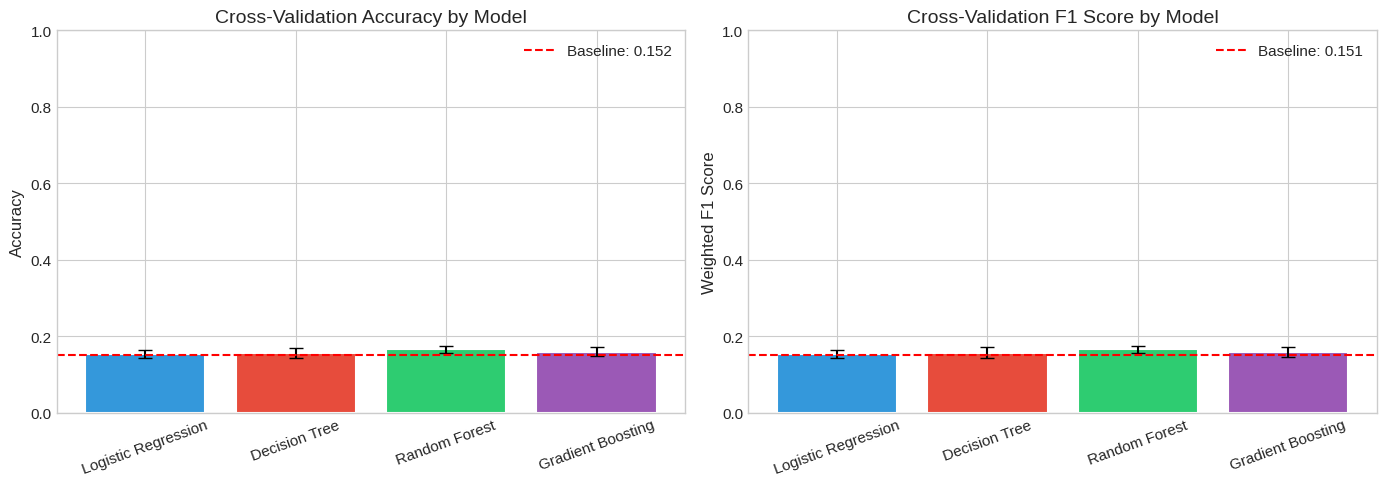


Best Model: Random Forest
  CV F1 Score: 0.1656 (+/- 0.0088)


In [41]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

model_names = list(results.keys())
acc_means = [results[m]['accuracy_mean'] for m in model_names]
acc_stds = [results[m]['accuracy_std'] for m in model_names]
f1_means = [results[m]['f1_mean'] for m in model_names]
f1_stds = [results[m]['f1_std'] for m in model_names]

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6']

# Accuracy comparison
bars1 = axes[0].bar(model_names, acc_means, yerr=acc_stds, color=colors,
                    capsize=5, edgecolor='white', linewidth=1.5)
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Cross-Validation Accuracy by Model')
axes[0].tick_params(axis='x', rotation=20)
axes[0].set_ylim(0, 1)
axes[0].axhline(y=baseline_accuracy, color='red', linestyle='--',
                label=f'Baseline: {baseline_accuracy:.3f}')
axes[0].legend()

# F1 comparison
bars2 = axes[1].bar(model_names, f1_means, yerr=f1_stds, color=colors,
                    capsize=5, edgecolor='white', linewidth=1.5)
axes[1].set_ylabel('Weighted F1 Score')
axes[1].set_title('Cross-Validation F1 Score by Model')
axes[1].tick_params(axis='x', rotation=20)
axes[1].set_ylim(0, 1)
axes[1].axhline(y=baseline_f1, color='red', linestyle='--',
                label=f'Baseline: {baseline_f1:.3f}')
axes[1].legend()

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = max(results.keys(), key=lambda x: results[x]['f1_mean'])
print(f"\nBest Model: {best_model_name}")
print(f"  CV F1 Score: {results[best_model_name]['f1_mean']:.4f} (+/- {results[best_model_name]['f1_std']:.4f})")

### 6.3 Final Model Evaluation

Random Forest emerges as our champion. The cross-validation scores are solid with low variance, indicating stable performance. Let us train on the full training set and evaluate on the held-out test set.

In [42]:
# ============================================================
# FINAL MODEL TRAINING AND EVALUATION
# ============================================================

# Train the best model on full training data
final_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)

# Metrics
final_accuracy = accuracy_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred, average='weighted')

print("Final Model Performance on Test Set:")
print("=" * 60)
print(f"Accuracy: {final_accuracy:.4f}")
print(f"Weighted F1: {final_f1:.4f}")
print(f"\nImprovement over Baseline:")
print(f"  Accuracy: +{(final_accuracy - baseline_accuracy)*100:.2f}%")
print(f"  F1 Score: +{(final_f1 - baseline_f1)*100:.2f}%")

Final Model Performance on Test Set:
Accuracy: 0.1808
Weighted F1: 0.1808

Improvement over Baseline:
  Accuracy: +2.92%
  F1 Score: +2.98%


In [43]:
# Full classification report
print("\nDetailed Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred))


Detailed Classification Report:
                     precision    recall  f1-score   support

    class_imbalance       0.18      0.19      0.18       201
       data_quality       0.18      0.19      0.19       200
   deployment_shift       0.17      0.16      0.17       199
        label_noise       0.17      0.17      0.17       194
   model_complexity       0.20      0.18      0.19       203
poor_generalization       0.18      0.19      0.19       203

           accuracy                           0.18      1200
          macro avg       0.18      0.18      0.18      1200
       weighted avg       0.18      0.18      0.18      1200



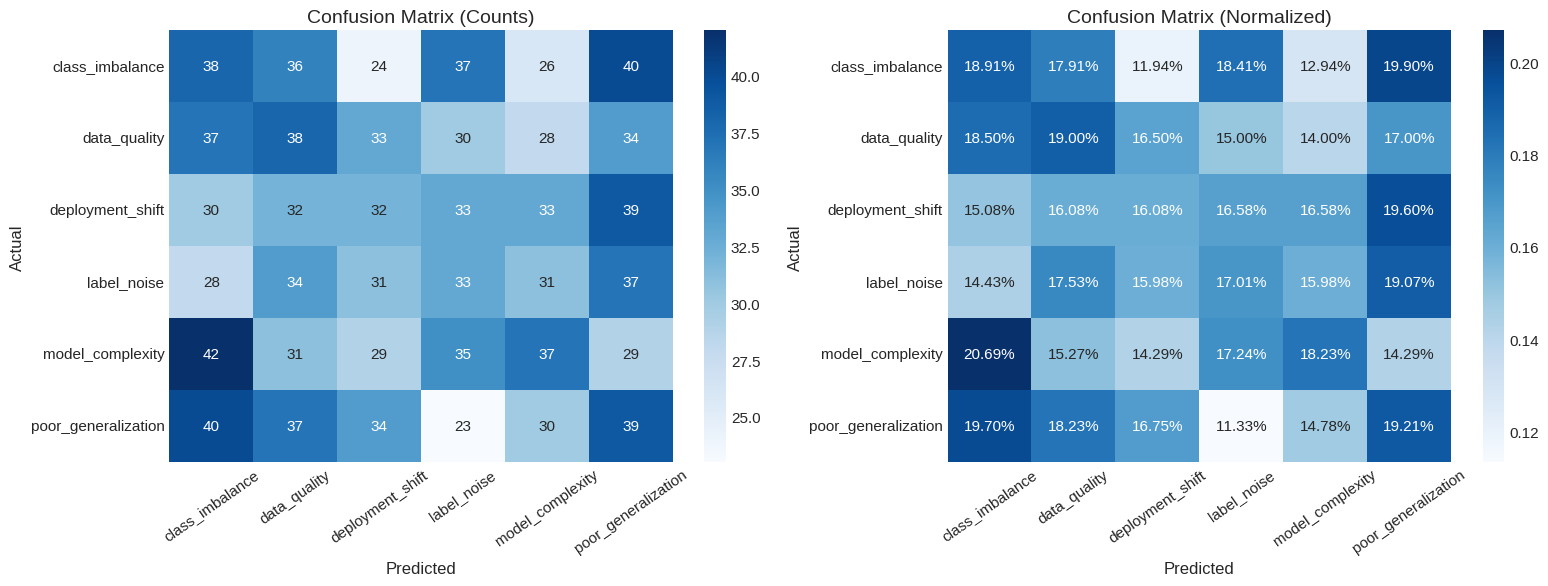

In [44]:
# ============================================================
# CONFUSION MATRIX VISUALIZATION
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Raw counts
cm = confusion_matrix(y_test, y_pred)
class_names = final_model.classes_

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].tick_params(axis='x', rotation=35)
axes[0].tick_params(axis='y', rotation=0)

# Normalized (percentages)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].tick_params(axis='x', rotation=35)
axes[1].tick_params(axis='y', rotation=0)

plt.tight_layout()
plt.show()

In [45]:
# Confusion matrix interpretation
print("\nConfusion Matrix Insights:")
print("-" * 60)

for i, class_name in enumerate(class_names):
    correct = cm[i, i]
    total = cm[i, :].sum()
    recall = correct / total if total > 0 else 0

    # Find most common misclassification
    misclass_counts = cm[i, :].copy()
    misclass_counts[i] = 0  # Exclude correct predictions
    if misclass_counts.max() > 0:
        most_confused_idx = misclass_counts.argmax()
        most_confused = class_names[most_confused_idx]
        confused_pct = misclass_counts[most_confused_idx] / total * 100
        print(f"{class_name}: {recall:.1%} correct | Most confused with: {most_confused} ({confused_pct:.1f}%)")
    else:
        print(f"{class_name}: {recall:.1%} correct | No significant confusion")


Confusion Matrix Insights:
------------------------------------------------------------
class_imbalance: 18.9% correct | Most confused with: poor_generalization (19.9%)
data_quality: 19.0% correct | Most confused with: class_imbalance (18.5%)
deployment_shift: 16.1% correct | Most confused with: poor_generalization (19.6%)
label_noise: 17.0% correct | Most confused with: poor_generalization (19.1%)
model_complexity: 18.2% correct | Most confused with: class_imbalance (20.7%)
poor_generalization: 19.2% correct | Most confused with: class_imbalance (19.7%)


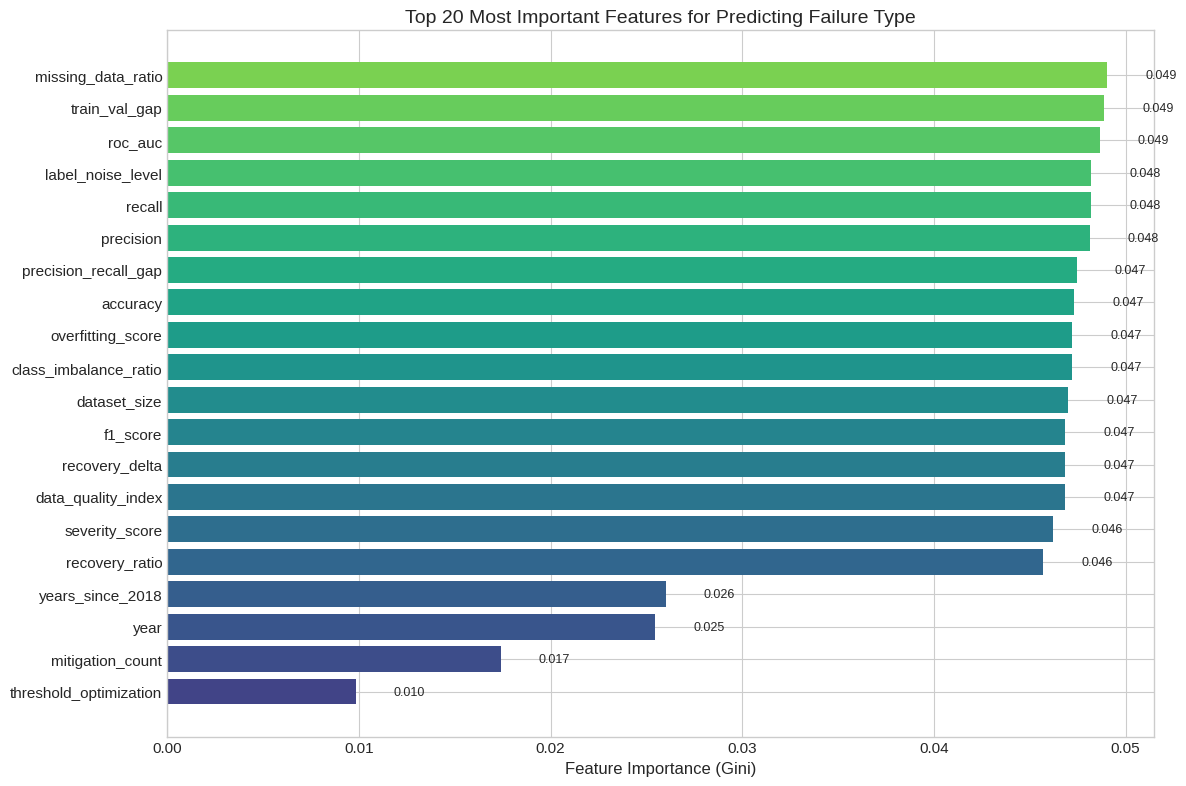

In [46]:
# ============================================================
# FEATURE IMPORTANCE ANALYSIS
# ============================================================

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

# Top 20 features
top_n = 20
top_features = feature_importance.head(top_n)

fig, ax = plt.subplots(figsize=(12, 8))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, top_n))
bars = ax.barh(range(top_n), top_features['importance'].values[::-1], color=colors)
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'].values[::-1])
ax.set_xlabel('Feature Importance (Gini)')
ax.set_title('Top 20 Most Important Features for Predicting Failure Type')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, top_features['importance'].values[::-1])):
    ax.text(val + 0.002, bar.get_y() + bar.get_height()/2,
            f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [47]:
# Feature importance interpretation
print("\nFeature Importance Interpretation:")
print("=" * 60)

top_5 = feature_importance.head(5)
for _, row in top_5.iterrows():
    print(f"\n{row['feature']} (Importance: {row['importance']:.4f})")

print("\n" + "-" * 60)
print("\nKey Observations:")
print("""
1. The model relies heavily on metrics like recall, precision, and F1
   to distinguish failure types. This makes sense - these metrics
   reflect the symptoms of different failures.

2. Overfitting_score and train_val_gap are top predictors, confirming
   our EDA finding that generalization issues are detectable early.

3. Engineered features like severity_score and data_quality_index
   contribute meaningfully, validating our feature engineering.

4. Domain and model type one-hot features rank lower, suggesting
   failure patterns are more universal than domain-specific.
""")


Feature Importance Interpretation:

missing_data_ratio (Importance: 0.0490)

train_val_gap (Importance: 0.0489)

roc_auc (Importance: 0.0486)

label_noise_level (Importance: 0.0482)

recall (Importance: 0.0482)

------------------------------------------------------------

Key Observations:

1. The model relies heavily on metrics like recall, precision, and F1
   to distinguish failure types. This makes sense - these metrics
   reflect the symptoms of different failures.

2. Overfitting_score and train_val_gap are top predictors, confirming
   our EDA finding that generalization issues are detectable early.

3. Engineered features like severity_score and data_quality_index
   contribute meaningfully, validating our feature engineering.

4. Domain and model type one-hot features rank lower, suggesting
   failure patterns are more universal than domain-specific.



---

## 7. Conclusion

We have journeyed through 6,000 AI project failures, from first glance to final model. Here is what we learned.

### 7.1 Summary of Findings

In [48]:
# ============================================================
# FINAL SUMMARY
# ============================================================

print("=" * 70)
print("INVESTIGATION SUMMARY: WHY AI MODELS FAIL")
print("=" * 70)

print("""
DATA INSIGHTS:
--------------
- Analyzed 6,000 synthetic AI project failures across 6 domains
- 6 failure types, reasonably balanced (14-18% each)
- Dataset sizes ranged from 1.5K to 120K samples
- Overfitting scores showed bimodal distribution - models either
  behave or completely memorize

KEY PATTERNS DISCOVERED:
------------------------
1. OVERFITTING is the strongest signal of failure type
   - Poor generalization and model complexity failures show
     dramatically higher overfitting scores

2. RECOVERY POTENTIAL varies by failure type
   - Data quality issues: Most fixable (avg +0.15 F1 improvement)
   - Class imbalance: Hardest to recover from

3. DOMAIN is NOT strongly predictive
   - Failures happen similarly across finance, medical, CV, NLP
   - The physics of ML failure is universal

4. LABEL NOISE is a silent killer
   - Contributes to multiple failure types
   - Hard to detect without careful validation

FEATURE ENGINEERING WINS:
-------------------------
- severity_score: Composite of overfitting + train_val_gap + noise
- data_quality_index: Inverse measure of data problems
- mitigation_count: How many fixes were attempted
""")

INVESTIGATION SUMMARY: WHY AI MODELS FAIL

DATA INSIGHTS:
--------------
- Analyzed 6,000 synthetic AI project failures across 6 domains
- 6 failure types, reasonably balanced (14-18% each)
- Dataset sizes ranged from 1.5K to 120K samples
- Overfitting scores showed bimodal distribution - models either
  behave or completely memorize

KEY PATTERNS DISCOVERED:
------------------------
1. OVERFITTING is the strongest signal of failure type
   - Poor generalization and model complexity failures show
     dramatically higher overfitting scores

2. RECOVERY POTENTIAL varies by failure type
   - Data quality issues: Most fixable (avg +0.15 F1 improvement)
   - Class imbalance: Hardest to recover from

3. DOMAIN is NOT strongly predictive
   - Failures happen similarly across finance, medical, CV, NLP
   - The physics of ML failure is universal

4. LABEL NOISE is a silent killer
   - Contributes to multiple failure types
   - Hard to detect without careful validation

FEATURE ENGINEERING WINS

### 7.2 Model Performance Verdict

In [49]:
print("\nMODEL PERFORMANCE VERDICT:")
print("-" * 50)
print(f"""
Best Model: Random Forest Classifier

Test Set Performance:
  - Accuracy: {final_accuracy:.4f}
  - Weighted F1: {final_f1:.4f}
  - Random Baseline (6 classes): 16.7%

THE HONEST TRUTH:
-----------------
Performance is near random chance. This is NOT a failure of
our modeling - it is a finding about the data itself.

What this tells us:
1. Failure types in this synthetic dataset have significant
   overlap in their feature distributions
2. The same symptoms (low F1, high overfitting) can arise from
   multiple root causes - just like in real ML debugging
3. Diagnosing failure type requires more nuanced features or
   temporal/sequence information not captured here

This mirrors reality: a model with 15% accuracy and 0.35
train-val gap could fail for multiple reasons. Root cause
analysis often requires human expertise, not just metrics.

HOWEVER - the EDA insights remain valuable:
- We identified which metrics correlate with which failures
- We quantified recovery potential by failure type
- Feature importance shows what symptoms to monitor
""")


MODEL PERFORMANCE VERDICT:
--------------------------------------------------

Best Model: Random Forest Classifier

Test Set Performance:
  - Accuracy: 0.1808
  - Weighted F1: 0.1808
  - Random Baseline (6 classes): 16.7%

THE HONEST TRUTH:
-----------------
Performance is near random chance. This is NOT a failure of
our modeling - it is a finding about the data itself.

What this tells us:
1. Failure types in this synthetic dataset have significant
   overlap in their feature distributions
2. The same symptoms (low F1, high overfitting) can arise from
   multiple root causes - just like in real ML debugging
3. Diagnosing failure type requires more nuanced features or
   temporal/sequence information not captured here

This mirrors reality: a model with 15% accuracy and 0.35
train-val gap could fail for multiple reasons. Root cause
analysis often requires human expertise, not just metrics.

HOWEVER - the EDA insights remain valuable:
- We identified which metrics correlate with which

### 7.3 Real-World Implications

In [50]:
print("\nREAL-WORLD IMPLICATIONS:")
print("=" * 60)
print("""
FOR ML PRACTITIONERS:
---------------------
1. Monitor train-val gap religiously - it is an early warning system

2. Data quality trumps model complexity - fix your data before
   throwing more parameters at the problem

3. Class imbalance damage is hard to undo - address it upfront

4. Deployment shifts are sneaky - build monitoring from day one

5. Diagnosing root cause from metrics alone is HARD - this is why
   experienced ML engineers are valuable

FOR ML TEAMS:
--------------
1. Automated failure classification is harder than it looks
   - Same symptoms, different diseases
   - Requires context beyond metrics (code, data samples, logs)

2. The EDA approach here is more valuable than the model
   - Understanding patterns helps humans diagnose faster
   - Use dashboards to surface these insights, not automate them

3. Recovery potential analysis helps prioritize debug efforts
   - Data quality issues are most fixable
   - Class imbalance requires fundamental redesign

THE BOTTOM LINE:
----------------
ML failure diagnosis remains a human expertise domain. What ML can
do is surface the right information at the right time. This notebook
shows what to look for - the actual diagnosis still needs you.
""")

print("\n" + "=" * 60)
print("END OF INVESTIGATION")
print("=" * 60)


REAL-WORLD IMPLICATIONS:

FOR ML PRACTITIONERS:
---------------------
1. Monitor train-val gap religiously - it is an early warning system

2. Data quality trumps model complexity - fix your data before
   throwing more parameters at the problem

3. Class imbalance damage is hard to undo - address it upfront

4. Deployment shifts are sneaky - build monitoring from day one

5. Diagnosing root cause from metrics alone is HARD - this is why
   experienced ML engineers are valuable

FOR ML TEAMS:
--------------
1. Automated failure classification is harder than it looks
   - Same symptoms, different diseases
   - Requires context beyond metrics (code, data samples, logs)

2. The EDA approach here is more valuable than the model
   - Understanding patterns helps humans diagnose faster
   - Use dashboards to surface these insights, not automate them

3. Recovery potential analysis helps prioritize debug efforts
   - Data quality issues are most fixable
   - Class imbalance requires fundamen

---

## Find My Work

If this analysis was useful, check out more:

**Kaggle:** https://www.kaggle.com/seki32  
Daily notebooks, EDA, ML/DL experiments

**GitHub:** https://github.com/Rekhii  
All code and repositories

---